# OCR on handwritten pages
Train a handwriting recognition model on my handwriting to automatically transcribe my mission journals.

State-of-the-art research so far: [Full Page Handwriting Recognition via Image to Sequence Extraction](https://paperswithcode.com/paper/full-page-handwriting-recognition-via-image), by Sumeet S. Singh and Sergey Karayev, 11-Mar-2021. See also: [YouTube presentation from the authors](https://youtu.be/BOIrib04fmE) (~1 hr.).
* Uses a convolutional neural network (ResNet34) as an encoder and a Transformer network as a decoder. Trained on thousands of samples from the IAM, WikiText, and proprietary datasets. The input data was also augmented to help the model generalize.

## References
* [PyTorch implementation](https://github.com/tobiasvanderwerff/full-page-handwriting-recognition) by Tobias van der Werff
* Training data: [Text Recognition Data Generator (`trdg`)](https://github.com/Belval/TextRecognitionDataGenerator), a Python package for generating images of random text that can be used to train handwriting recognition (or OCR) models
* Potential training data: [IAM dataset files, official website](https://fki.tic.heia-fr.ch/databases/download-the-iam-handwriting-database)
* Potential training data: [IAM forms dataset, on Kaggle](https://www.kaggle.com/naderabdalghani/iam-handwritten-forms-dataset)
* Potential training data: [Images of handwritten names, Kaggle](https://www.kaggle.com/landlord/handwriting-recognition)

Others
* [Stanford's CS231n course PDF outline of handwritten text recognition](http://cs231n.stanford.edu/reports/2017/pdfs/810.pdf), including a discussion of the IAM dataset and various data augmentation methods
* [Towards Data Science article](https://towardsdatascience.com/build-a-handwritten-text-recognition-system-using-tensorflow-2326a3487cd5) and associated [GitHub repo](https://github.com/githubharald/SimpleHTR) demonstrating a handwritten text recognition task in TensorFlow using a convolutional neural network combined with a LSTM net to recognize individual words (not full paragraphs or pages).

## To-dos and Dones
- watch Aladdin Person's YouTube video on saving and loading PyTorch models, since I will likely need to use checkpoints to train my handwriting recognition model
- learn how to save and load checkpoints
- use trdg library to create huge amounts of training samples. Implement some blurring (occasional blurry pictures), slanting (just a little), left margins (spaces or indentation) on some lines
- use Pillow to merge training samples in a way that builds the superscript text style I often use in my journal (paste some lines of text in a smaller version and in between other lines)
- update my transcriptions with beginning of sequence and end of sequence tokens and with tokens for drawings, deleted text, and insertions
- learn what local (vs global) attention means
- include dropout for regularization
- learn how to do data augmentation (picture adjustments and blank pages)
- quick draft version: use torchvision's pre-built resnet and transformer modules to create and test the network

## Research notes
[**Research paper**](https://paperswithcode.com/paper/full-page-handwriting-recognition-via-image)
* First successful implementation of full-page handwritten text recognition
* Does not require uniformly formatted data (like the IAM dataset)
* Achieves a character-error rate (CER) of about 6%

[**YouTube presentation from the authors**](https://youtu.be/BOIrib04fmE)
* Research goals that this paper addressed:
 - Multi-paragraph text detection in proper sequence
 - Capture indentation
 - Ignore scratched-out text, math, tables, or unrecognized symbols
 - Use character-level generation to avoid the constraint of a language model (with a fixed vocabulary size)
* Prior to performing image-to-sequence extraction, you need to convert the image from grayscale to black-and-white (to assist in focusing on the text)
* This method is called "offline handwritten text recognition (HTR)", which means the input is an image of text. In contrast, "online HTR" means that the input is pen strokes, with directional and timing data, such as what could be obtained from a digital stylus on a Microsoft Surface or Apple iPad.
* You can include special sequence tags like `<deleted text>` or `<side note>` and the model can learn to recognize those regions
* "If you added a Transformer at the end of the CNN encoder, it would probably increase accuracy, but we found it wasn't necessary and model size was too large with a Transformer encoder as well"
* "You don't need line-number encodings in the decoder, if you omit them, your model will perform almost as well."
* "Decoder uses local attention, though Transformers commonly use global attention. We found that local attention didn't reduce efficacy and trained faster, since we could use larger batch sizes."
* "We didn't use beam search"
* "We used ResNet34 for the encoder, which has 21M parameters. You could use any CNN, though. We did not use the pre-trained version and trained ours from scratch."
* "Inference takes 4.6 seconds per page on a CPU thread, when the input image is 2500x2200 pixels with 456 characters and 11.65 lines."
* "Decoder is a Transformer with 6M parameters. We use cross-entropy loss, dropout, and cross attention on the entire image."
* "The longest part, where we spent the most time, was preparing the data to use for model training. Ideally, you want 100k samples. We had about 20k after augmenting our proprietary 13k samples. We also used WikiText rendered in over 300 fonts, with varying degrees of skewness, text layout on page, contrast, brightness, and blank images. You really need a lot of data to train these models on. The goal is to have a large enough sample base that it is independent and identically distributed, so mini-batch samples all reflect roughly the same (identical) data distribution."
* "Model doesn't perform well on out-of-distribution data."
* "The model is sensitive to image padding"
* Encoder takes up a lot of parameters, potentially an improvement area would be creating a more efficient encoder.
* "Character error rate on full-page data is about 6.3%"
* "During training, weights are 32 bits, gradients are 16 bits"
* "We use AWS Lambda for inferencing, so inferencing happens on CPUs"

In [ ]:
# %pip install opencv-contrib-python-headless
import cv2                              # image preprocessing with OpenCV
from scipy.ndimage import interpolation # skew correction
import os                               # working with files
import re                               # RegEx pattern matching
import random                           # generating random samples
import matplotlib.pyplot as plt         # data visualization and image display
import numpy as np                      # numerical operations
import pandas as pd                     # tabular data manipulation
import seaborn as sns                   # statistical visualization
from tqdm.notebook import tqdm          # progress bars

## Stats for image data generation

To generate training images that resemble the images of my journal, I will need the following:
1. The average number of words per line on each page of my journal
2. The average number of lines per page in my journal
3. The average height (in pixels) of each line of text in my journal (avg_img_height ÷ avg_lines_per_page)
4. Approximate number of indented lines per page
5. Approximate number of blank lines per page
6. A handful of fonts (>5?) that resemble my handwriting

Using that information, I can then use the `trdg` Python library (TextRecognitionDataGenerator) to create images of words arranged in lines. I can vary the number of words per line to match the average words per line in my journal. Each line (image) of words will have a height in pixels equal to the average height (in pixels) of the lines in the full-page images of my journal. Based on the images of pags of my journal, that height is approximately 62 pixels.

The default setting for word generation using `trdg` would also include a top margin that represents the empty space between each line of text in my journal. Furthermore, I would use a left margin to simulate indented lines (e.g., at the start of paragraphs), creating a collection of line-images to be sampled from where each image has an indented line.

I can use the `Pillow` library to concatenate (paste) line-images together to form generated full-page text images. While stitching together line-images, I could  make the training set more robust by incorporating augmentations such as tilts, lighting adjustments, or the addition of noise.

Finally, those generated images will be preprocessed, the same as the actual images, to prepare them to input into the neural network. For example, the images may be converted to grayscale, binarized (conversion to black and white), or rotated (to correct tilt).

---

Find the average line length for text in my journal

In [ ]:
folderpath = r"data\Journal 4 labels"
alltext = ''
filecount = 0

for onefile in os.listdir(folderpath):
    if "Vol_4" in onefile and "SKIPPED" not in onefile:
        with open(os.path.join(folderpath, onefile), mode='rt', encoding='utf-8') as txtfile:
            alltext += txtfile.read()
            filecount += 1

blankline_count = len(re.findall('\n\n', string=alltext))
indentedline_count = len(re.findall('\n    ', string=alltext))

all_lines = alltext.split('\n')
line_lengths = []
line_len_chars = []
for line in all_lines:
    if len(line.split()) > 3:
        line_lengths.append(len(line.split()))
        line_len_chars.append(len(line))

avg_line_len = sum(line_lengths)/len(line_lengths)
# Below, filecount*2 is because the .txt files currently have 2 pages per file
avg_lines_per_file = len(all_lines) / (filecount * 2)
print(f"Avg line length is {avg_line_len:,.1f} words")
print(f"Avg line length is {sum(line_len_chars)/len(line_len_chars):,.1f} characters")
print(f"Avg lines per file is {avg_lines_per_file:,.1f}")
print(f"Avg words per page is: {avg_line_len * avg_lines_per_file:,.1f}")
# There are 10 pages transcribed in the test set. Each of 5 files includes
# 2 blank lines that are added to separate one page from the next. Therefore,
# I remove 10 lines from the blanklines count.
print(f"Avg number of blank lines per page: {(blankline_count-10)/10:,.1f}")
print(f"Avg number of indented lines per page: {indentedline_count/10:,.1f}")

Avg line length is 17.9 words
Avg line length is 94.2 characters
Avg lines per file is 32.4
Avg words per page is: 578.7
Avg number of blank lines per page: 0.8
Avg number of indented lines per page: 5.5


Avg words per line: 17.9
Min words per line: 4.0
Max words per line: 41.0
Standard deviation of words per line: 4.9


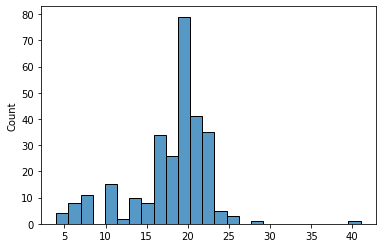

In [ ]:
words_per_line = np.array(line_lengths)

# Stats about word count
print(f"Avg words per line: {words_per_line.mean():,.1f}")
print(f"Min words per line: {words_per_line.min():,.1f}")
print(f"Max words per line: {words_per_line.max():,.1f}")
print(f"Standard deviation of words per line: {words_per_line.std():,.1f}")

# Histogram plot
sns.histplot(words_per_line)
plt.show()

In [ ]:
histogram_data = np.histogram(words_per_line, bins=range(0,words_per_line.max()+1))
# Each bin gives the upper limit of data to be counted in that bin
# The lower limit is the bin before it.
# print(histogram_data)

# Compute the softmax across the words_per_line histogram result
# See: https://stackoverflow.com/questions/34968722/how-to-implement-the-softmax-function-in-python
# softmax_distr = np.exp(histogram_data[0]) / np.sum(np.exp(histogram_data[0]), axis=0)
# print(softmax_distr)

prob_distr = histogram_data[0]/np.sum(histogram_data[0])
# Examine probabilities for 10-26 words
for num in range(10,27):
    print(f"{histogram_data[1][num+1]}: {prob_distr[num]:.1%}")

11: 3.9%
12: 1.4%
13: 0.7%
14: 2.8%
15: 0.7%
16: 2.8%
17: 5.3%
18: 6.7%
19: 9.2%
20: 13.1%
21: 14.8%
22: 14.5%
23: 8.5%
24: 3.9%
25: 1.8%
26: 1.1%
27: 0.0%


In [ ]:
histogram_data

(array([ 0,  0,  0,  0,  4,  0,  8,  7,  4,  0, 11,  4,  2,  8,  2,  8, 15,
        19, 26, 37, 42, 41, 24, 11,  5,  3,  0,  0,  1,  0,  0,  0,  0,  0,
         0,  0,  0,  0,  0,  0,  1], dtype=int64),
 array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41]))

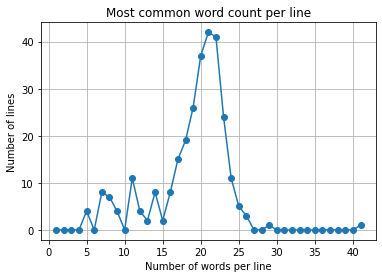

In [ ]:
plt.plot(histogram_data[1][1:], histogram_data[0], '-o')
plt.title('Most common word count per line')
plt.xlabel('Number of words per line')
plt.ylabel('Number of lines')
plt.grid()
plt.show()

Use only line lengths from 10-25 words

In [ ]:
words_in_line = histogram_data[1][10:26]
word_counts = histogram_data[0][10:26]

prob_distr = word_counts/np.sum(word_counts)
# Examine probabilities for 10-25 words
for num in range(16):
    print(f"{words_in_line[num]}: {prob_distr[num]:.1%}")
    
print(f"Total: {np.sum(prob_distr):.1%}")

10: 4.3%
11: 1.6%
12: 0.8%
13: 3.1%
14: 0.8%
15: 3.1%
16: 5.8%
17: 7.4%
18: 10.1%
19: 14.3%
20: 16.3%
21: 15.9%
22: 9.3%
23: 4.3%
24: 1.9%
25: 1.2%
Total: 100.0%


Create list to model probability distribution from a randomly-chosen number

In [ ]:
words_in_line.tolist()

[10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]

In [ ]:
prob_distr.cumsum().round(5).tolist()

[0.04264,
 0.05814,
 0.06589,
 0.0969,
 0.10465,
 0.13566,
 0.1938,
 0.26744,
 0.36822,
 0.51163,
 0.67442,
 0.83333,
 0.92636,
 0.96899,
 0.98837,
 1.0]

In [ ]:
words = [10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25]
prob = [0.04264,
 0.05814,
 0.06589,
 0.0969,
 0.10465,
 0.13566,
 0.1938,
 0.26744,
 0.36822,
 0.51163,
 0.67442,
 0.83333,
 0.92636,
 0.96899,
 0.98837,
 1.0]

In [ ]:
# Find the closest index to the one chosen by a random float
# See: https://www.adamsmith.haus/python/answers/how-to-find-the-numpy-array-element-closest-to-a-given-value-in-python
# and: https://stackoverflow.com/questions/2566412/find-nearest-value-in-numpy-array

def word_count(word_counts, cumulative_probabilities):
    words = np.array(word_counts)
    probs = np.array(cumulative_probabilities)
    rand_num = random.random()
    # Find the difference between the probability distribution
    # and the random float
    diff = np.abs(probs - rand_num)
    # Find the index of the smallest difference
    idx = diff.argmin()
    # Return the word count of the smallest difference
    return words[idx]

In [ ]:
word_count(words, prob)

17

Other approach: use a normal distribution rather than calculated probabilities

In [ ]:
# Other approach: use a normal distribution
# with a mean of 18 words and a standard deviation
# of 5 words

# See: https://docs.python.org/3/library/random.html#random.gauss
int(round(random.gauss(18, 5), 0))

23

## Image preprocessing

### References
* [Preprocessing for OCR](https://towardsdatascience.com/pre-processing-in-ocr-fc231c6035a7), TowardsDataScience blog article (free access)
* [YouTube video on image preprocessing for OCR](https://www.youtube.com/watch?v=ADV-AjAXHdc), from Python Tutorials for Digital Humanities
 - Related [Jupyter notebook](https://github.com/wjbmattingly/ocr_python_textbook/blob/main/02_02_working%20with%20opencv.ipynb) on GitHub

Create list of image filepaths

Display images

Technique learned from: https://github.com/wjbmattingly/ocr_python_textbook/blob/main/02_02_working%20with%20opencv.ipynb

In [ ]:
def display_img(image, dpi=100, img_title='Image'):
    '''
    Uses `matplotlib.pyplot.imshow` to display an input image.
    Input `image` can be either a filepath to an image or
    an OpenCV image object (a `numpy.ndarray`).
    '''
    if type(image) == str:
        # input is a filepath
        img = plt.imread(image)
        img_title = image[image.rfind("\\") + 1:]
    else:
        # input is an OpenCV image object, which
        # is a numpy.ndarray
        img = image

    # Store the first two dimensions of the image's shape (height, width)
    height, width = img.shape[:2]

    # Tuple of (width, height) for display in Matplotlib
    # Since Matplotlib uses inches (rather than pixels)
    # as its figsize parameter
    figsize = (width / float(dpi), height / float(dpi))
    # figsize = (img.shape[1]/float(dpi), img.shape[0]/float(dpi))

    plt.figure(figsize=figsize)
    # Turn off display of axis labels (spines, ticks, labels)
    plt.axis('off')
    plt.title(img_title)
    # Display image
    # cmap='gray' doesn't change the colors displayed unless
    # the image file is first converted to grayscale
    plt.imshow(img, cmap='gray')
    plt.show()

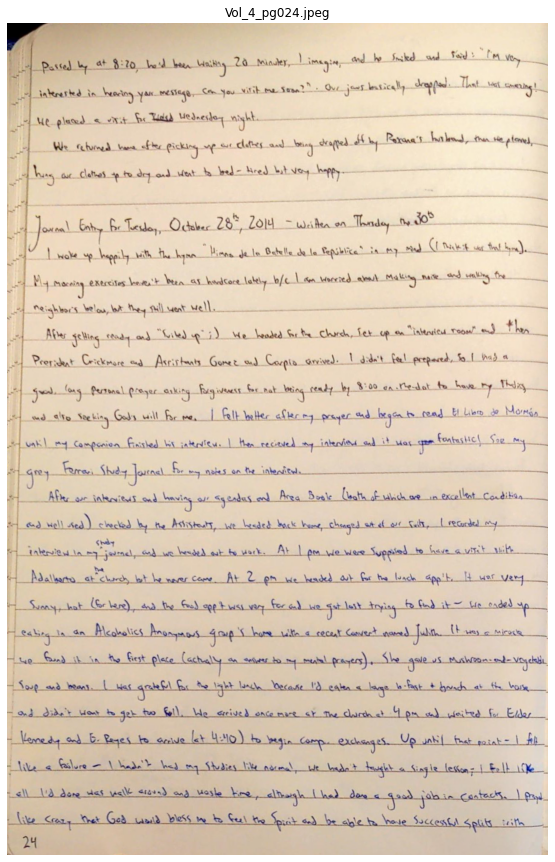

In [ ]:
image_files = []
folderpath = r"data\images"
for img in os.listdir(folderpath):
    image_files.append(os.path.join(folderpath, img))

display_img(image_files[2], dpi=120)

Convert image to grayscale

In [ ]:
def img_to_grayscale(image):
    '''
    Converts an image in RGB format to
    its equivalent in grayscale.

    Input is a filepath to an image or
    an OpenCV Image object (a numpy.ndarray).
    '''
    if type(image) == str:
        # input is a filepath
        image = cv2.imread(image)

    return cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

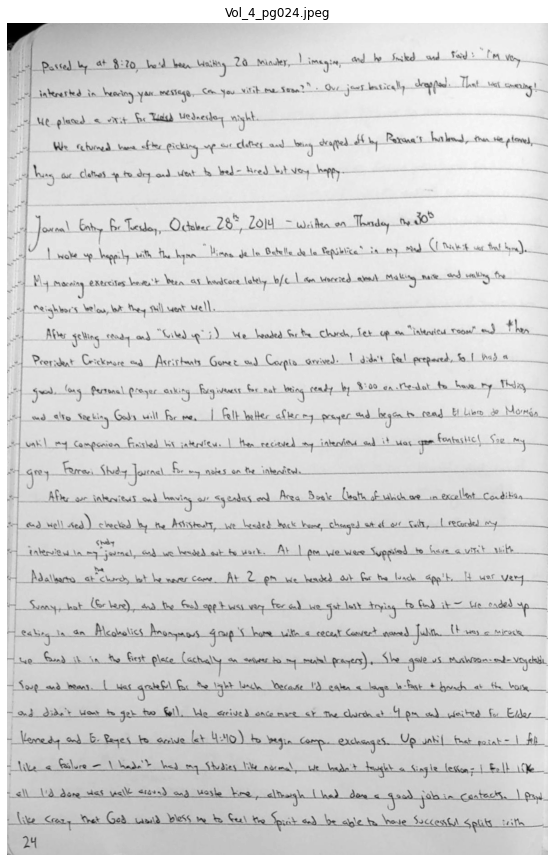

In [ ]:
gray_img = img_to_grayscale(image_files[2])
img_title = image_files[2][image_files[2].rfind("\\") + 1:]

display_img(gray_img, dpi=120, img_title=img_title)

Binarize image (convert to black and white)

Reference: [Preprocessing for OCR](https://towardsdatascience.com/pre-processing-in-ocr-fc231c6035a7), TowardsDataScience article.

Another technique for adaptive thresholding is the `Sauvola` algorithm from `scikit-image`. See: https://scikit-image.org/docs/dev/auto_examples/segmentation/plot_niblack_sauvola.html

In [ ]:
def binarize(image, method='fixed', threshold=127, window_size=7):
    '''
    Returns a binarized image as an OpenCV image object,
    which is a `numpy.ndarray`.

    Parameters
    ---
    `image`: an OpenCV image or a filepath to an image
    
    `method`: {'fixed', 'otsu', 'adaptive'}, default='fixed'
    The method to be used for determining whether each pixel should
    be black or white. Default is 'fixed', which uses the provided
    `threshold` value to determine whether a pixel becomes black or white.
    If 'adaptive', uses local region to create different thresholds 
    for each part of the image, based on the `window_size` parameter.
    If 'otsu', uses the Otsu function to determine a fixed threshold
    for the image.

    `threshold`: int in [0, 255], default=127
    If the method is 'fixed', then this value sets the threshold
    to be used when determining whether each pixel should be black or white.
    This value is ignored for the 'otsu' and 'adaptive' methods.

    `window_size`: int, default=7. Must be odd (e.g., window_size % 2 == 1).
    The distance (in pixels) to be used when applying a `method` of 'adaptive'.
    For example, a value of 7 means to use a 7x7 pixel window centered on the
    current pixel to calculate threshold values. The larger the value, the bolder
    words tend to become. There is a middle zone (e.g., 13-49) that creates 
    lots of noise in the image; values lower than that concentrate noise 
    around letters, and values greater than that zone (e.g., >51) reduce
    the noise in blank spaces, but make letters appear more bold.
    '''
    if type(image) == str:
        # input is a filepath
        image = cv2.imread(image)

    # Convert to grayscale
    image = img_to_grayscale(image)
    
    if method == 'adaptive':
        binary_img = cv2.adaptiveThreshold(image, maxValue=255,
            adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
            thresholdType=cv2.THRESH_BINARY, blockSize=window_size, C=2)
    elif method == 'otsu':
        # use fixed threshold with an automatically-determined threshold value
        # thresh, binary_img = cv2.threshold(image, thresh=threshold, maxval=255, type=cv2.THRESH_BINARY, dst=cv2.THRESH_OTSU)
        thresh, binary_img = cv2.threshold(image, thresh=threshold, maxval=255, type=cv2.THRESH_OTSU)
    else:
        # use fixed threshold
        thresh, binary_img = cv2.threshold(image, thresh=threshold, maxval=255, type=cv2.THRESH_BINARY)
    
    return binary_img

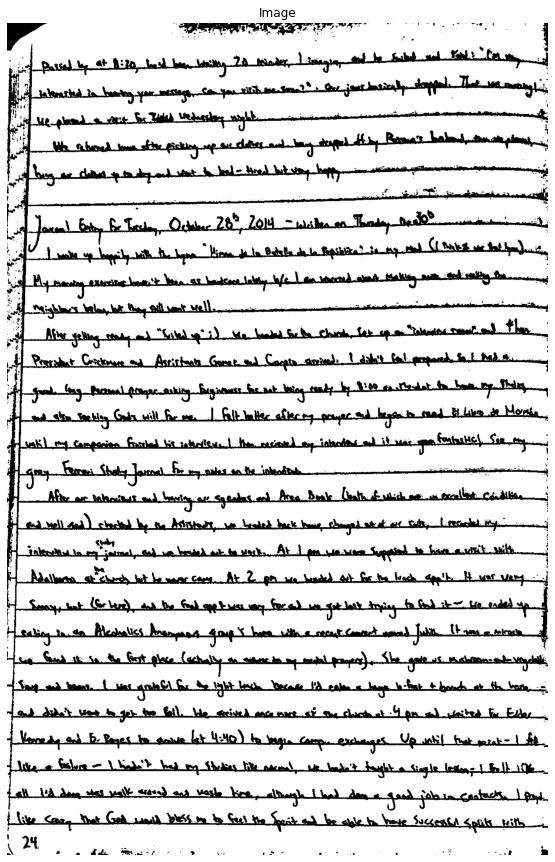

In [ ]:
display_img(binarize(image_files[2], method='adaptive', threshold=165, window_size=201), dpi=120)

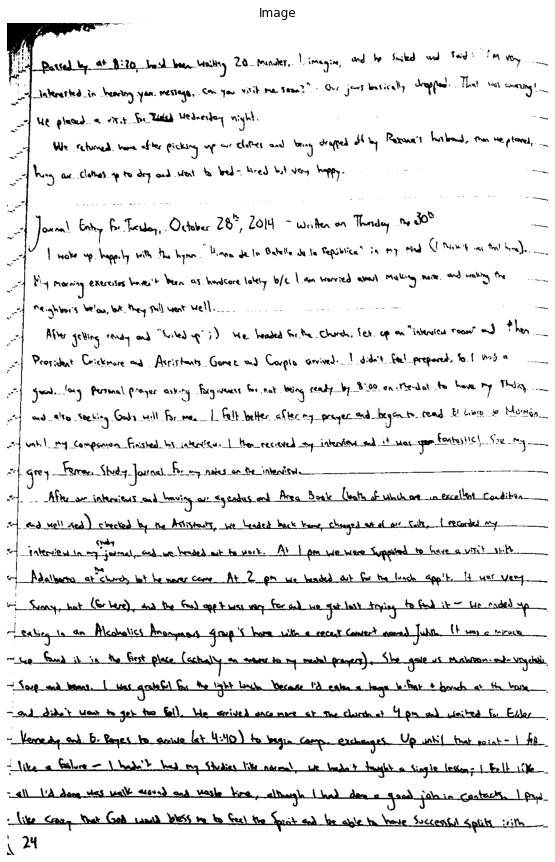

In [ ]:
display_img(binarize(image_files[2], method='otsu', threshold=165, window_size=7), dpi=120)

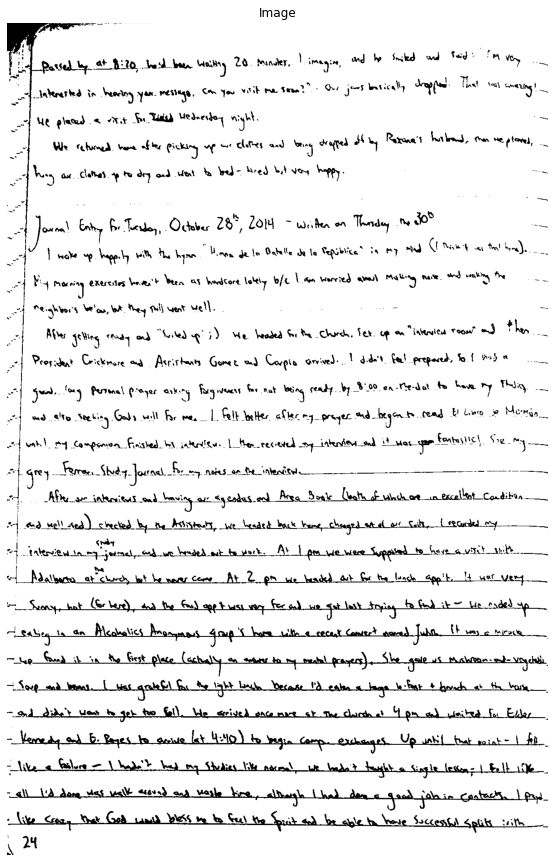

In [ ]:
display_img(binarize(image_files[2], method='fixed', threshold=165, window_size=7), dpi=120)

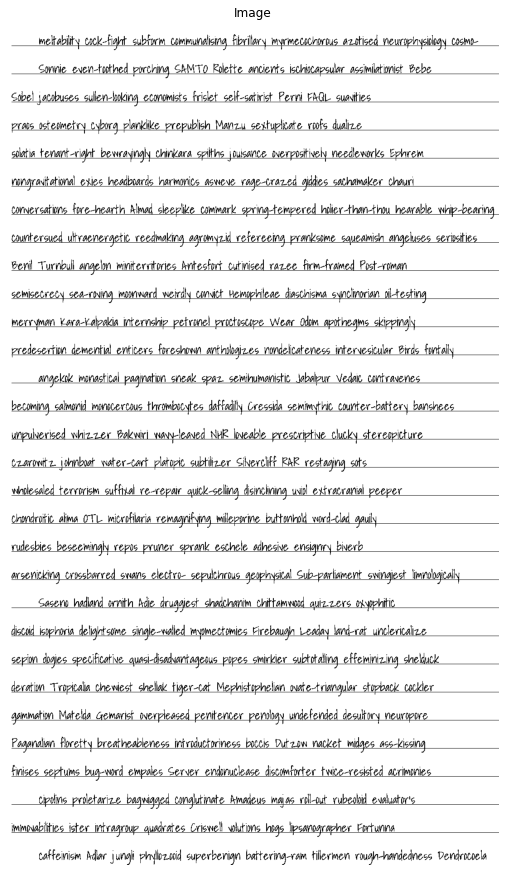

In [ ]:
img_file = r"training_data\images\00011.jpg"
display_img(binarize(img_file, method='otsu', threshold=165, window_size=65), dpi=120)

### Skew correction

Uses the projection profile method as described in a [StackOverflow answer](https://stackoverflow.com/a/57965160/17005348). A similar technique is described in the [Preprocessing in OCR](https://towardsdatascience.com/pre-processing-in-ocr-fc231c6035a7) TowardsDataScience article and in [Avil Page's blog](https://avilpage.com/2016/11/detect-correct-skew-images-python.html). A different technique that doesn't rely on `scipy`'s interpolation method (but uses much more code) can be found on [PyImageSearch](https://pyimagesearch.com/2017/02/20/text-skew-correction-opencv-python/).

In [ ]:
def determine_score(np_array, angle):
        '''
        Calculates the score: the maximum difference
        between peaks on the histogram of summed pixels
        across each row.

        An alternative implementation would use the
        variance in the histogram of row-wise pixel sums.
        '''
        rotated_image = interpolation.rotate(np_array, angle, reshape=False, order=0)
        # Find the row-wise sum of pixel values
        histogram = np.sum(rotated_image, axis=1)
        # Compute the maximum difference between peaks
        # Uses L2 error, or sum of squared difference
        score = np.sum((histogram[1:] - histogram[:-1]) ** 2)
        return histogram, score

def correct_skew(image, angle_precision=0.1, limit=5):
    '''
    Takes an input `image` (either a file path or a `numpy.ndarray`)
    and uses the projection profile method to find the optimal skew
    correction angle, then corrects the skew and returns the corrected
    image as a `numpy.ndarray`.

    Parameters
    ---
    `image`: a file path to an image or a `numpy.ndarray`
    `angle_precision`: sets the amount (in degrees) that the angle
    will be changed between each iteration as the algorithm checks
    which angle is the best for correcting skew in the image.
    `limit`: the maximum amount of change (in degrees) that
    will be checked. Enter a positive value, the algorithm will
    check all angles from [-limit, limit] with stepsize of angle_precision.

    Algorithm source:
    https://stackoverflow.com/questions/57964634/python-opencv-skew-correction-for-ocr/57965160#57965160
    '''
    if type(image) == str:
        # input is a filepath
        image = cv2.imread(image)

    # Convert to grayscale
    gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Convert to inverse binary using Otsu's method
    inv_binary_img = cv2.threshold(gray_image, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)[1]

    scores = []
    angles = np.arange(-limit, limit + angle_precision, angle_precision)
    for angle in angles:
        histogram, score = determine_score(inv_binary_img, angle)
        scores.append(score)
    
    best_angle = angles[scores.index(max(scores))]

    # Rotate input image using cv2
    height, width = image.shape[:2]
    center = (width //2, height // 2)
    rotation_matrix = cv2.getRotationMatrix2D(center, best_angle, scale=1.0)
    rotated_image = cv2.warpAffine(image, rotation_matrix, (width, height), flags=cv2.INTER_CUBIC, borderMode=cv2.BORDER_REPLICATE)

    # Convert to grayscale and binarize
    final_image = binarize(rotated_image, method='otsu')

    return final_image    

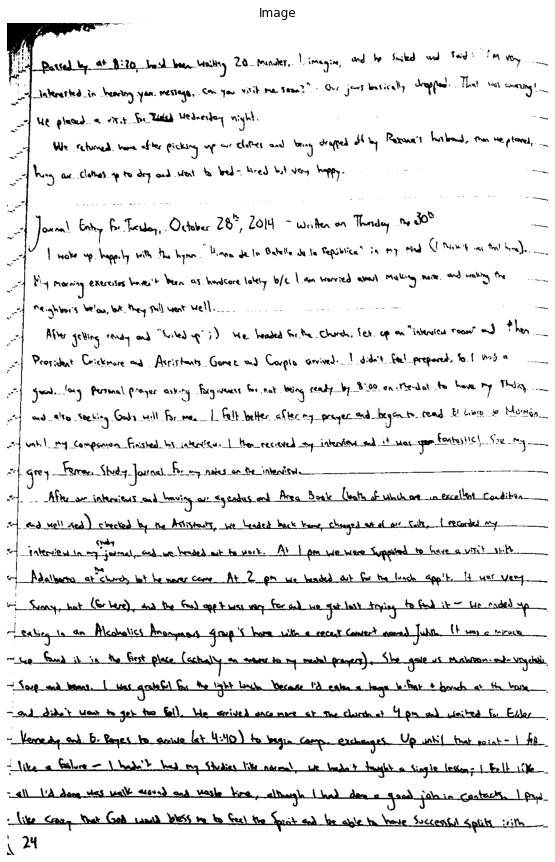

In [ ]:
display_img(binarize(image_files[2], method='otsu'), dpi=120)

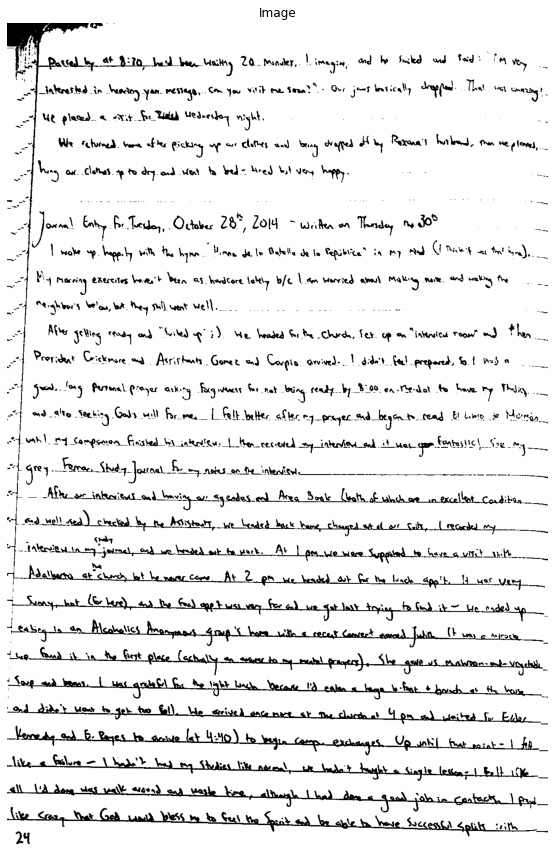

In [ ]:
display_img(correct_skew(image=image_files[2], angle_precision=0.5, limit=3), dpi=120)

## Process all images
Steps involved: converting to grayscale and binarizing. Skew correction wasn't very helpful since the skew of the image changes across the page and the images are already aligned quite well.

If this implementation is unsuccessful, I may try simply converting images to grayscale rather than binary, since that is what Singh et al. did in [Full Page Handwriting Recognition via Image to Sequence Extraction](https://paperswithcode.com/paper/full-page-handwriting-recognition-via-image), (pg. 8).

In [ ]:
def preprocess_images(input_folder: str, output_folder: str):
    '''
    Converts images to a binary representation using the Otsu method.

    Parameters
    ---
    `input_folder`: str
    Path to the folder where the input images are located

    `output_folder`: str
    Path to the folder where output images are to be saved.
    If the folder does not exist, it will be created.
    '''
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)
    
    # Create progress bar
    progress_bar = tqdm(total=len(os.listdir(input_folder)))

    for image in os.listdir(input_folder):
        img_file = os.path.join(input_folder, image)
        binarized_image = binarize(img_file, method='otsu')
        # Save image
        outfile = os.path.join(output_folder, image)
        cv2.imwrite(filename=outfile, img=binarized_image, params=[cv2.IMWRITE_JPEG_QUALITY, 60])
        progress_bar.set_description(f"{image}")
        progress_bar.update(n=1)

In [ ]:
# First, the 10 images of my journal
input_folder = r"data\images"
output_folder = r"data\processed_images"

preprocess_images(input_folder, output_folder)

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# Next, the 10,000 training images
input_folder = r"training_data\images"
output_folder = r"training_data\processed_images"

preprocess_images(input_folder, output_folder)

  0%|          | 0/10000 [00:00<?, ?it/s]

# Neural Network
Adapted from [Full Page Handwriting Recognition via Image to Sequence Extraction](https://paperswithcode.com/paper/full-page-handwriting-recognition-via-image), by Singh et al. in March 2021. See pages 4-8 of the paper.

## Model architecture

Screenshot from pg. 4 of the paper by Singh et al.

<img src="/imgs/Model-Architecture_FPHR_Singh-et-al_2021.png" width="600">


By the way, Visual Studio Code has trouble loading images in Markdown if the images are stored locally. Here are other potential ways to view the image using Markdown, from [StackOverflow answer](https://stackoverflow.com/questions/32370281/how-to-embed-image-or-picture-in-jupyter-notebook-either-from-a-local-machine-o):

```md
![Screenshot from pg. 4 of the paper by Singh et al.](/imgs/Model-Architecture_FPHR_Singh-et-al_2021.png)


<img src="Model-Architecture_FPHR_Singh-et-al_2021.png" style="height:300px">
```

## Library imports

In [31]:
# PyTorch modules for neural network
import torch                                # PyTorch
import torch.nn as nn                       # Neural network module
import torch.optim as optim                 # Optimizer module (e.g., SGD, Adam)
import torchvision                          # Computer vision module
from torchvision import transforms          # Image augmentation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("GPU is available, device set to GPU." if torch.cuda.is_available() 
        else "GPU unavailable, device set to CPU.")

# Other packages
import numpy as np                          # Array and mathematical functions
from tqdm.notebook import tqdm              # Progress bars
import matplotlib.pyplot as plt             # Plotting functionality
from PIL import Image                       # Loading and manipulating images
import random                               # Create train-test split of data
import shutil                               # Move files
import os                                   # Work with files and folders
import math                                 # Use the log() function (for positional encoding)
import string                               # Character lists (e.g., for character-level vocab)
from torchmetrics import Metric             # Package for computing measurements on PyTorch models
import editdistance                         # Implementation of Levenshtein edit distance
from typing import Callable, Optional       # Modules for type annotations (type hints)

GPU unavailable, device set to CPU.


## Metrics and utility functions
Adapted from: Tobias van der Werff's GitHub repo: [full-page-handwriting-recognition -> metrics.py](https://github.com/tobiasvanderwerff/full-page-handwriting-recognition/blob/master/src/metrics.py)

In [ ]:
# from torchmetrics import Metric
# import editdistance

class CharacterErrorRate(Metric):
    '''
    Calculates the character error rate, a measurement of the percentage
    of characters that were predicted incorrectly.

    Calculation: Levenshtein edit distance / length of target.
    '''

    def __init__(self):
        super().__init__()
        self.add_state("edits", default=torch.Tensor([0]), dist_reduce_fx="sum")
        self.add_state("total_chars", default=torch.Tensor([0]), dist_reduce_fx="sum")
    
    def update(self, predictions, targets):
        '''
        Updates the running count of the number of edits
        and ground truth characters.

        Parameters
        ---
        `predictions`: Tensor of shape (batch_size, predicted_characters)
        `targets`: Tensor of shape (batch_size, target_characters)
        '''
        assert predictions.ndim == targets.ndim
        
        sos_token_idx = token_to_index['<START>']
        eos_token_idx = token_to_index['<END>']

        # Check if the first token is the start token (i.e., the standard situation)
        if (predictions[:, 0] == sos_token_idx).all():
            # Remove the start token
            predictions = predictions[:, 1:]
        
        eos_idxs_pred = (predictions == eos_token_idx).float().argmax(dim=1).tolist()
        eos_idxs_tgt = (targets == eos_token_idx).float().argmax(dim=1).tolist()

        for i, (p, t) in enumerate(zip(predictions, targets)):
            eos_idx_p, eos_idx_t = eos_idxs_pred[i], eos_idxs_tgt[i]
            p = p[:eos_idx_p] if eos_idx_p else p
            t = t[:eos_idx_t] if eos_idx_t else t
            # Convert the predictions and target tensors to
            # strings of indexes.
            # Note that the editdistance package can handle
            # any hashable iterable, not just strings.
            # see: https://pypi.org/project/editdistance/#distance-with-any-object
            p_str, t_str = map(lambda tsr: str(tsr.flatten().tolist()), (p, t))
            edit_d = editdistance.eval(p_str, t_str)

            self.edits += edit_d
            self.total_chars += t.numel()
        
    def compute(self):
        '''Calculate the character error rate'''
        return self.edits.float() / self.total_chars

In [ ]:
# Testing the tensor-to-string function used on line 49 in the cell above
t = torch.tensor([[9, 8, 3], [1, 4, 91]])
to_str = "".join(map(str, t.flatten().tolist()))
to_str

'9831491'

### Character-to-index
This is my implementation of word-to-index and index-to-word functionality.

I've included a function to convert labels (text strings) into `long` Tensors with integer indices into the vocabulary dictionary, and a function to convert `long` Tensors into strings.

In [ ]:
# # Clean up label .txt files by removing the <START> and <END> tokens,
# # since those are simple to add during training and prediction.
# # To replace and overwrite (not append), either open the file in read mode, store the text, then
# # reopen the file in write mode and write the changed text, OR use file.seek(0) before file.write()
# # and finish with file.truncate().
# # See: https://stackoverflow.com/questions/11469228/replace-and-overwrite-instead-of-appending/11469328#11469328
# total_count = 0
# folders = [
#     r'training_data\labels\train',
#     r'training_data\labels\test',
#     r'data\labels\train',
#     r'data\labels\test']

# for folder in folders:
#     total_count += len(os.listdir(folder))

# p_bar = tqdm(total=total_count, leave=False)
# for folder in folders:
#     for onefile in os.scandir(folder):
#         with open(onefile.path, mode='r', encoding='utf-8') as labelfile:
#             all_text = labelfile.read()
#         all_text = all_text.replace('<START>', '')
#         all_text = all_text.replace('<END>', '')
#         with open(onefile.path, mode='w', encoding='utf-8') as labelfile:
#             labelfile.write(all_text)
#         p_bar.update(n=1)
# p_bar.close()

  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# import string

# Define a set to store character-level vocabulary from the dataset
dataset_vocab = set()

# Find all possible characters the model will encounter during training
folders = [
    r'training_data\labels\train',
    r'training_data\labels\test',
    r'data\labels\train',
    r'data\labels\test']

total_count = 0
for folder in folders:
    total_count += len(os.listdir(folder))

p_bar = tqdm(total=total_count, leave=False)
p_bar.set_description('Reading files in dataset')
for folder in folders:
    for onefile in os.scandir(folder):
        with open(onefile.path, mode='rt', encoding='utf-8') as labelfile:
            # Wrapping labelfile.read() in list() converts the string to
            # a character-level list
            dataset_vocab.update(list(labelfile.read()))
        p_bar.update(n=1)
p_bar.close()


new_characters = [char for char in dataset_vocab if char not in list(string.printable)]
special_tokens = ['<START>', '<END>', '<PAD>', '<INSERT>', '</INSERT>']
all_chars = list(string.printable) + new_characters
all_chars = sorted(all_chars)
all_chars = special_tokens + all_chars

index_to_token = dict(enumerate(all_chars))
token_to_index = {char: i for i, char in index_to_token.items()}

print(f"Total number of characters: {len(token_to_index)}")
print(token_to_index.keys())

  0%|          | 0/10010 [00:00<?, ?it/s]

Total number of characters: 116
dict_keys(['<START>', '<END>', '<PAD>', '<INSERT>', '</INSERT>', '\t', '\n', '\x0b', '\x0c', '\r', ' ', '!', '"', '#', '$', '%', '&', "'", '(', ')', '*', '+', ',', '-', '.', '/', '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', ':', ';', '<', '=', '>', '?', '@', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z', '[', '\\', ']', '^', '_', '`', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '{', '|', '}', '~', '¡', '¿', 'É', 'á', 'í', 'ñ', 'ó', 'ú', '•', '❤', '🙂'])


Text-to-tensor conversion

In [56]:
def text_to_tensor(
    text: str,
    token_to_idx: dict,
    start_token: str = '<START>',
    end_token: str = '<END>',
    pad_token: str = '<PAD>',
    max_len: int = 3500,
    multichar_tokens: list = ['<INSERT>', '</INSERT>'],
    placeholder_chars: list = ['🔴', '🟠'],
    device: torch.device = device,
    dtype: torch.dtype = torch.uint8) -> torch.Tensor:
    '''
    Takes an input string (labels) and converts it to
    a Tensor of d_type Long (i.e., an integer Tensor),
    where each item in the Tensor is an index into the
    `token_to_idx` vocabulary dictionary.

    Also adds the `start_token` to the beginning of
    the tensor, the `end_token` after all the tokens
    in the `text`, and fills the remaining space up
    to `max_len` tokens with the `pad_token`.

    Returns a Tensor of d_type Long.

    Parameters
    ---
    `text`: str
        The text string to be converted into a Tensor.
        This will be the label (target) text.
    `token_to_idx`: dict
        A token-to-index dictionary for each token
        in the vocabulary.
    `start_token`: str, default='<START>'
        The token to be added at the beginning of each 
        `text` sequence.
    `end_token`: str, default='<END>'
        The token to be added after all the tokens in the
        `text` sequence.
    `pad_token`: str, default='<PAD>'
        The token to use for padding the given `text` up to
        the `max_len` number of tokens.
    `max_len`: int, default=3500
        The maximum length (in tokens) of the provided `text`.
        Raises an error if `text` exceeds `max_len`.
        If `text` has fewer tokens than `max_len`, the remaining
        tokens will be padded with `pad_token`.
    `multichar_tokens`: list, default=['<INSERT>', '</INSERT>']
        Since this is a character-level vocabulary, any multi-character
        sequences that should be treated as a single token must be replaced
        with a single-character placeholder before iterating through the `text`
        character-by-character, and will be converted back into the 
        multi-character token during that iteration.
    `placeholder_chars`: list, default=['🔴', '🟠']
        The single-character placeholders that will take the place of
        multi-character tokens so the function can iterate through the
        `text` character-by-character but still recognize the correct
        tokens. These tokens must not exist within the `token_to_idx`.
    `device`: a torch.device object
        The device on which to place the returned tensor. Can be either
        torch.device('cpu') or torch.device('cuda').
    `dtype`: a torch datatype, default=torch.uint8
        See: https://pytorch.org/docs/stable/tensor_attributes.html
        for a list of the acceptable data types. Since I am using
        a character-level vocabulary with fewer than 256 characters,
        torch.uint8 suits my needs and save memory.
    '''
    assert len(text) <= max_len, (
        f"The given `text` has more tokens (characters) than the `max_len` setting allows. "
        f"Please increase the size of max_len to accomodate the input text. "
        f"len(text)={len(text)}, and max_len={max_len}."
    )

    if type(multichar_tokens) != list:
        multichar_tokens = [multichar_tokens]

    if type(placeholder_chars) != list:
        placeholder_chars = [placeholder_chars]
    
    for char in placeholder_chars:
        assert char not in list(token_to_idx.keys()), (
            f"The provided placeholder character {char} is in the `token_to_idx`."
            + "Please use a placeholder character not found in the `token_to_idx`"
        )
    
    # List of token indices for each character in the input text.
    # Begin the sequence with the '<START>' token.
    index_list = [token_to_idx[start_token]]

    # Replace multi-character tokens with single-character placeholders
    for i, token in enumerate(multichar_tokens):
        replaced_text = text.replace(token, placeholder_chars[i])
    
    # Iterate through the text character-by-character and return integer indices
    for char in replaced_text:
        if char in placeholder_chars:
            idx = placeholder_chars.index(char)
            index_list.append(token_to_idx[multichar_tokens[idx]])
        else:
            index_list.append(token_to_idx[char])
    
    # End the sequence with the '<END>' token.
    index_list.append(token_to_idx[end_token])

    # Fill remaining space in sequence with '<PAD>' token up to max_len
    if len(index_list) < max_len:
        num_pads = max_len - len(index_list)
        pad_list = [token_to_idx[pad_token]] * num_pads
        index_list += pad_list


    # Convert the index_list into a Tensor
    return torch.tensor(index_list, dtype=dtype, device=device)

Tensor-to-text conversion

In [57]:
def tensor_to_text(
    tensor: torch.Tensor,
    idx_to_token: dict) -> str:
    '''
    Takes an input Tensor and converts it to
    a string by returning the `idx_to_token` token
    for each index given in the tensor.

    Returns a string.

    Parameters
    ---
    `tensor`: torch.Tensor
        The integer-type Tensor that holds indices
        to tokens in the idx_to_token dict.
    `idx_to_token`: dict
        An index-to-token dictionary for each token
        in the vocabulary.
    '''
    return_string = ''
    for item in tensor:
        return_string += idx_to_token[item.item()]
    return return_string

Testing the conversion functions

In [ ]:
test_str = """<START>This is a test paragraph, to see if
the text-to-tensor and tensor-to-text functions work correctly.
    This is a sample indented line.

This is a new paragraph, with a <INSERT>superscript</INSERT> added.

It's also possible to have special characters, like ~ or á.<END>"""

test_tensor = text_to_tensor(test_str, token_to_idx=token_to_index)
print(test_tensor[:20])
print('='*20, '\n', '='*20, sep='')
print(tensor_to_text(test_tensor, idx_to_token=index_to_token))

tensor([38, 61, 62, 43, 60, 62, 40, 62, 82, 83, 93, 10, 83, 93, 10, 75, 10, 94,
        79, 93], dtype=torch.uint8)
<START>This is a test paragraph, to see if
the text-to-tensor and tensor-to-text functions work correctly.
    This is a sample indented line.

This is a new paragraph, with a <INSERT>superscript</INSERT> added.

It's also possible to have special characters, like ~ or á.<END>


## Dataset and DataLoader

### Split data into training and validation sets

In [ ]:
def train_test_split(
    path_to_image_folder: str, 
    path_to_label_folder: str, 
    test_pct: float = 0.2) -> None:
    '''
    Using the starting directories, `path_to_image_folder` and `path_to_label_folder`,
    creates two sub-directories in each folder: '/train' and '/test'.
    Takes a sample of `test_pct` percent of the data and
    moves it into the '/test' directory, and all the rest of the samples are moved
    into the '/train' directory.

    Relies on images and labels having the same name (not the same extension).
    For example, if the image file were '001.jpeg', then its label must be '001.txt'.
    '''
    # List only the files (not directories) in each folder
    # See: https://stackabuse.com/python-list-files-in-a-directory/
    # Or: https://stackoverflow.com/questions/14176166/list-only-files-in-a-directory
    image_files = [one_file.name for one_file in os.scandir(path_to_image_folder) if one_file.is_file()]
    label_files = [one_file.name for one_file in os.scandir(path_to_label_folder) if one_file.is_file()]

    # Confirm that there are the same number of files in both directories
    err_msg = ("The number of files in the image_folder and label_folder must be the same."
               + f"\nThere are {len(image_files)} files in the image_folder "
               + f"and {len(label_files)} files in the label_folder.")
    assert len(image_files) == len(label_files), err_msg

    # Create train and test folders
    for directory in [path_to_image_folder, path_to_label_folder]:
        test_folder = os.path.join(directory, 'test')
        train_folder = os.path.join(directory, 'train')
        if not os.path.exists(test_folder):
            os.makedirs(test_folder)
        if not os.path.exists(train_folder):
            os.makedirs(train_folder)
    
    # Select test and train subsets (removing file extensions)
    #  assumes all image files have the same file extension
    #  and all label files have the same file extension
    image_extension = os.path.splitext(image_files[0])[1]
    label_extension = os.path.splitext(label_files[0])[1]
    # Strip extension off of file names
    file_names = [os.path.splitext(one_file)[0] for one_file in image_files]
    # Determine size to sample
    sample_size = int(len(file_names) * test_pct)
    test_files = random.sample(file_names, sample_size)
    train_files = [one_file for one_file in file_names if one_file not in test_files]

    # Move files using shutil
    # See: https://datatofish.com/move-file-python/
    progress_bar = tqdm(total=len(file_names), leave=False)
    progress_bar.set_description("Moving files.")
    for one_file in file_names:
        folder_type = ('test' if one_file in test_files else 'train')
        for folder, ext in zip([path_to_image_folder, path_to_label_folder], [image_extension, label_extension]):
            old_path = os.path.join(folder, one_file + ext)
            new_path = os.path.join(folder, folder_type, one_file + ext)
            shutil.move(old_path, new_path)
        progress_bar.update(n=1)
    
    progress_bar.close()
    
    print('Folders created\n', '-'*20, sep='')
    print("Training folders:"
       + f"\nImages: {os.path.join(path_to_image_folder, 'train')}"
       + f"\nLabels: {os.path.join(path_to_label_folder, 'train')}")
    print('-'*20)
    print("Testing folders:"
       + f"\nImages: {os.path.join(path_to_image_folder, 'test')}"
       + f"\nLabels: {os.path.join(path_to_label_folder, 'test')}")

In [ ]:
# train_test_split(
#     path_to_image_folder = r"data\processed_images",
#     path_to_label_folder = r"data\labels",
#     test_pct = 0.3
# )

  0%|          | 0/10 [00:00<?, ?it/s]

Folders created
--------------------
Training folders:
Images: C:\Users\Ryan\OneDrive\Documents\Code\Python\CS 474, Deep Learning\Final Project\processed_images\train
Labels: C:\Users\Ryan\OneDrive\Documents\Code\Python\CS 474, Deep Learning\Final Project\labels\train
--------------------
Testing folders:
Images: C:\Users\Ryan\OneDrive\Documents\Code\Python\CS 474, Deep Learning\Final Project\processed_images\test
Labels: C:\Users\Ryan\OneDrive\Documents\Code\Python\CS 474, Deep Learning\Final Project\labels\test


In [ ]:
# train_test_split(
#     path_to_image_folder = r"training_data\processed_images",
#     path_to_label_folder = r"training_data\labels",
#     test_pct = 0.2
# )

  0%|          | 0/10000 [00:00<?, ?it/s]

Folders created
--------------------
Training folders:
Images: C:\Users\Ryan\Desktop\Deep learning project\processed_images\train
Labels: C:\Users\Ryan\Desktop\Deep learning project\labels\train
--------------------
Testing folders:
Images: C:\Users\Ryan\Desktop\Deep learning project\processed_images\test
Labels: C:\Users\Ryan\Desktop\Deep learning project\labels\test


### Dataset
The dataset retrieves an item (image with its associated text label) from either a 'train' or 'test' folder and returns a (image, label) tuple, where both the image and label are `torch.Tensor`s.

**Augmentations**

The dataset will also implement augmentation, including:
* padding images to match the size of the largest image in the dataset (so all images in all batches are the same size). For the 10,000 training images and 10 fine-tuning images I am using, the **largest width is 2295 pixels**, and the **largest height is 1884 pixels**.
* scaling
* rotation
* brightness
* (background color?)
* contrast
* perspective
* Gaussian noise

During training, images can be randomly placed anywhere within the padding dimensions of the largest image in the batch, but during testing the images should be centered (still within padding).

For more information on augmentation used in the paper, see Singh et al., p. 10-11 ("Image Augmentation" and "Data Sampling" sections).

**Dataset references**
* [Examples of custom datasets](https://github.com/utkuozbulak/pytorch-custom-dataset-examples)
* [PyTorch docs: Datasets](https://pytorch.org/vision/stable/datasets.html)
* [PyTorch docs: DataLoaders and Datasets](https://pytorch.org/docs/stable/data.html)
* [PyTorch docs: custom datasets (in particular, see `VisionDataset`)](https://pytorch.org/vision/stable/datasets.html#base-classes-for-custom-datasets)

**Transforms references**
* [PyTorch docs: Transforming and Augmenting Images](https://pytorch.org/vision/stable/transforms.html)
* [PyTorch docs: illustrated examples of transforms](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html)
* [PyTorch source code (GitHub): transforms.py](https://github.com/pytorch/vision/blob/main/torchvision/transforms/transforms.py)

**Note:** `torchvision.transforms.RandomApply(transforms=[], p=0.5)` will apply _all_ transformations in the list if _any_ transformation is applied (based on the probability).

See also: one-step transform: [`TrivialAugmentWide`](https://pytorch.org/vision/stable/auto_examples/plot_transforms.html#trivialaugmentwide)

In [17]:
class FPHRdataset(torch.utils.data.Dataset):
    def __init__(
        self,
        path_to_image_folder,
        path_to_label_folder,
        max_width,
        max_height,
        augmentation_likelihood: float = 0.5,
        train = True):
        '''
        Args
        ---
        `path_to_image_folder`: str
            Root directory where images are stored. Assumes that
            within that directory are two sub-directories:
            'test' and 'train', each with images.
        `path_to_label_folder`: str
            Root directory where labels are stored. Assumes that
            within that directory are two sub-directories:
            'test' and 'train', each with labels.
        `max_width`: int
            Defines the size for each image; that is, each image will be padded
            so its width equals max_width (in pixels). Should be at least
            as large as the maximum width (in pixels) in any image
            in the entire dataset.
        `max_height`: int
            Defines the size for each image; that is, each image will be padded
            so its height equals max_height (in pixels). Should be at least
            as large as the maximum height (in pixels) in any image
            in the entire dataset.
        `augmentation_likelihood`: float, default=0.5
            Sets the probability that any one of the augmentation transforms
            will be applied to the input image.
        `train`: bool, default=True
            If True, uses the 'train' subdirectories in the `path_...`
            arguments. If False, uses the 'test' subdirectories.
        '''
        # No need to inherit from the base class (torch.utils.data.Dataset)
        # That is, we don't need: super().__init__()

        self.max_width = max_width
        self.max_height = max_height
        self.augment_prob = augmentation_likelihood
        self.train = train

        if self.train:
            # Store the paths to the directories for images and labels
            self.path_to_image_folder = os.path.join(path_to_image_folder, 'train')
            self.path_to_label_folder = os.path.join(path_to_label_folder, 'train')
        else:
            self.path_to_image_folder = os.path.join(path_to_image_folder, 'test')
            self.path_to_label_folder = os.path.join(path_to_label_folder, 'test')
        
        # Store all image file paths in memory
        self.image_files = [os.path.join(self.path_to_image_folder, file) for file in os.listdir(self.path_to_image_folder)]
        # Store all label file paths in memory
        self.label_files = [os.path.join(self.path_to_label_folder, file) for file in os.listdir(self.path_to_label_folder)]


    def create_transformations(self, padding, t_horizontal, t_vertical, augment_prob, train=True):
        '''
        Compose the transformations to be applied to the input image.
        '''
        if train:
            # Perform augmentations with torchvision.transforms.
            # Order of transforms:
            # 1. ColorJitter: adjusts brightness, contrast, and saturation
            # 2. RandomAffine: changes scale, rotates image, and translates (moves) image
            # 3. RandomPerspective: shifts the perspective of the image
            # 4. GaussianBlur: appplies a Gaussian blur to the image (in place of adding Gaussian noise)
            # 5. Pad: pad image so all images are the same size 
            # 6. ToTensor: Converts the image into a torch.Tensor
            augmentations = transforms.Compose(
                transforms = [
                    transforms.RandomApply(
                        transforms = [
                            transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                            transforms.RandomAffine(degrees=2.5, translate=(t_horizontal, t_vertical), scale=(0.9, 1.0)),
                            transforms.RandomPerspective(distortion_scale=0.1, p=augment_prob)],
                        p = augment_prob),
                    transforms.RandomApply(
                        transforms = [
                            transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 1.0))],
                        p = augment_prob),
                    transforms.Pad(padding=padding),
                    transforms.ToTensor()
                    ])
        else:
            # For inference (testing), just center the image within padding space
            augmentations = transforms.Compose([transforms.Pad(padding=padding), transforms.ToTensor()])
        
        return augmentations


    def __getitem__(self, index):
        # =====================================
        # Set values needed for transformations
        #  (padding, vertical and horizontal translation)
        input_img = Image.open(self.image_files[index])
        width, height = input_img.size
        pad_width, pad_height = (self.max_width - width, self.max_height - height)

        if any([pad_width % 2 == 1, pad_height % 2 == 1]):
            # padding cannot be evenly split between sides of image
            pad_left = pad_width // 2
            pad_right = pad_width - pad_left
            pad_top = pad_height // 2
            pad_bottom = pad_height - pad_top
            padding = (pad_left, pad_top, pad_right, pad_bottom)
        else:
            # padding can be evenly split between sides of image
            pad_leftright = pad_width // 2
            pad_topbottom = pad_height // 2
            padding = (pad_leftright, pad_topbottom)

        # Determine the fraction of image width and height used for translation
        #  such that there is still padding on all sides of the image.
        # left/right translation
        t_horizontal = (pad_width / 2) / self.max_width
        # top/bottom translation
        t_vertical = (pad_height / 2) / self.max_height
        # =====================================
        # =====================================

        # Compose the transformations for the input
        augmentations = self.create_transformations(
            padding = padding,
            t_horizontal = t_horizontal,
            t_vertical = t_vertical,
            augment_prob = self.augment_prob,
            train = self.train)
        # Apply transformations
        img_tensor = augmentations(input_img)
        
        with open(self.label_files[index], mode='rt', encoding='utf-8') as labelfile:
            target_label = labelfile.read()
        
        target_label_tensor = text_to_tensor(
            text=target_label,
            token_to_idx=token_to_index,
            multichar_tokens=['<INSERT>', '</INSERT>'],
            placeholder_chars=['🔴', '🟠'],
            device=device,
            dtype=torch.uint8
        )

        # print(f"Padding size: {padding}")
        # print(f"Horizontal translation percent {t_horizontal:.2f}")
        # print(f"Vertical translation percent {t_vertical:.2f}")
        
        return (img_tensor, target_label_tensor)


    def __len__(self):
        return len(self.image_files)

Test the Dataset

In [3]:
train_dataset = FPHRdataset(
    path_to_image_folder = r'training_data\processed_images',
    path_to_label_folder = r'training_data\labels',
    max_width = 2300,
    max_height = 1900,
    augmentation_likelihood = 0.5,
    train = True
)

test_dataset = FPHRdataset(
    path_to_image_folder = r'training_data\processed_images',
    path_to_label_folder = r'training_data\labels',
    max_width = 2300,
    max_height = 1900,
    augmentation_likelihood = 0.5,
    train = False
)

Image size (width, height): (2300, 1900)


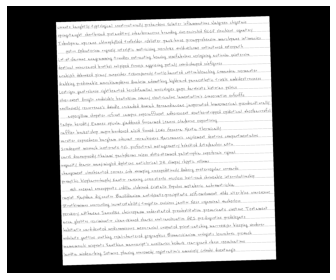

<START>cornuto haughtily typtological nonstructurally prehardens Sclater inflammations Walgreen chigetais
spring-taught shortbread postauditory subarboraceous branding vine-encircled NCCF slouchiest signatory
Tubulipora upcrane chlorophylloid toolholder reblister pack-horse preapprehension marchpane intimacies
    petro Epibaterium rugosely osteolytic metricising overchoke world-welcome untinctured osteopath
Lot-et-Garonne anagramming trundles extracting heaving semifabulous neologizing actinula quinternion
destinal unincreased brethel outpiped Forneys aggrieving petaly sword-shaped subfigures
arabiyeh debunked piracy vanquisher teknonymously turtle-haunted cotton-bleaching Comandra overmaster
drabbing predivinable monochlamydeous Anaheim adsmithing highboard panaesthetic trinkle ambidextrousness
Lestrigon gastrelcosis righthearted heredofamilial musicologies gape darwinists historian pelvics
silver-sweet Azeglio nondivisible beatnikism swanny electricalize lamentation's Conservative e

In [ ]:
img, label = train_dataset[10]

# For info on image modes, see: https://pillow.readthedocs.io/en/stable/handbook/concepts.html#concept-modes
# 'L' means "grayscale"
tensor_to_PIL = transforms.ToPILImage(mode='L')
PIL_img = tensor_to_PIL(img)
print(f"Image size (width, height): {PIL_img.size}")

plt.imshow(PIL_img, cmap='gray')
plt.axis('off')
plt.tight_layout()
plt.show()

print(label)

Test transformations

Image size (width, height): (2000, 1500)


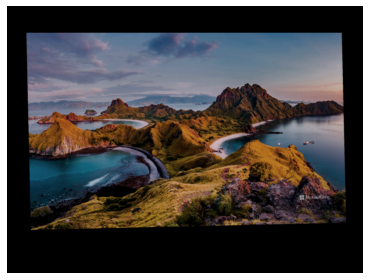

In [ ]:
test_img = Image.open(r"C:\Users\Ryan\Pictures\Background Photos\BingWallpaper - Komodo Island Indonesia.jpg")

augment_prob = 0.5

# Input image width, height
width, height = (1920, 1200)
desired_width, desired_height = (2000, 1500)

pad_width, pad_height = (desired_width - width, desired_height - height)

if any([pad_width % 2 == 1, pad_height % 2 == 1]):
    # padding cannot be evenly split between sides of image
    pad_left = pad_width // 2
    pad_right = pad_width - pad_left
    pad_top = pad_height // 2
    pad_bottom = pad_height - pad_top
    padding = (pad_left, pad_top, pad_right, pad_bottom)
else:
    # padding can be evenly split between sides of image
    pad_leftright = pad_width // 2
    pad_topbottom = pad_height // 2
    padding = (pad_leftright, pad_topbottom)

# Determine the fraction of image width and height used for translation
# such that there is still padding on all sides of the image
# left/right translation
t_horizontal = (pad_width / 2) / desired_width
# top/bottom translation
t_vertical = (pad_height / 2) / desired_height

augmentations = transforms.Compose(
    transforms = [
        transforms.RandomApply(
            transforms = [
                transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0.5),
                transforms.RandomAffine(degrees=2.5, translate=(t_horizontal, t_vertical), scale=(0.9, 1.0)),
                transforms.RandomPerspective(distortion_scale=0.1, p=augment_prob)],
            p = augment_prob), 
        transforms.RandomApply(
            transforms = [
                transforms.GaussianBlur(kernel_size=5, sigma=(0.1, 3.0))],
            p = augment_prob),
        transforms.Pad(padding=padding)
        ])

adjusted_img = augmentations(test_img)
print(f"Image size (width, height): {adjusted_img.size}")

plt.imshow(adjusted_img)
plt.axis('off')
plt.tight_layout()
plt.show()

### DataLoader
The DataLoader prepares batches from the Dataset.

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=8, shuffle=True, pin_memory=True)

## Positional encoding

### 1D positional encoding (for decoder Transformer)

Implementation reference: Tobias van der Werff's GitHub repo: [full-page-handwriting-recognition/src/models](https://github.com/tobiasvanderwerff/full-page-handwriting-recognition/blob/47a2d27fc40815898474e9f74badc7d544740fee/src/models.py#L18).

See also:
* [The Annotated Transformer](http://nlp.seas.harvard.edu/2018/04/03/attention.html#positional-encoding), Harvard's implementation of the "Attention Is All You Need" (2017) paper by Vaswani et al.
* [How to Code the Transformer in PyTorch](https://blog.floydhub.com/the-transformer-in-pytorch/#giving-our-words-context-the-positional-encoding), FloydHub blog
* [Transformers from Scratch](http://peterbloem.nl/blog/transformers#input-using-the-positions), Peter Bloem's blog, with accompanying code on [GitHub](https://github.com/pbloem/former) and videos on [YouTube](https://www.youtube.com/playlist?list=PLIXJ-Sacf8u60G1TwcznBmK6rEL3gmZmV). Note that Peter Bloem uses positional _embeddings_ rather than encodings. The drawback with embeddings is that each possible sequence length needs to be seen during training, or that length will not be learned by the network.

#### Find the maximum sequence length seen during training or inference.

In [ ]:
# Find the maximum number of characters (i.e., sequence length) the model will encounter during training
folders = [
    r'training_data\labels\train',
    r'training_data\labels\test',
    r'data\labels\train',
    r'data\labels\test']
seq_lengths = []
for folder in folders:
    for onefile in os.scandir(folder):
        with open(onefile.path, mode='rt', encoding='utf-8') as labelfile:
            seq_lengths.append(len(labelfile.read()))

print(f'Number of files: {len(seq_lengths)}')
print(f'Maximum sequence length: {max(seq_lengths)}')
print(f'Minimum sequence length: {min(seq_lengths)}')

Number of files: 10010
Maximum sequence length: 3298
Minimum sequence length: 1926


In [ ]:
print(f'Average sequence length: {sum(seq_lengths) / len(seq_lengths):,.0f}')
print(f'Avg seq. len. for training and test data: {sum(seq_lengths[:10000]) / len(seq_lengths[:10000]):,.0f}')
print(f'Avg seq. len. for inference data: {sum(seq_lengths[10000:]) / len(seq_lengths[10000:]):,.0f}')

print('-'*30)
print(f'Max seq. len. for training and test data: {max(seq_lengths[:10000]):,.0f}')
print(f'Max seq. len. for inference data: {max(seq_lengths[10000:]):,.0f}')

Average sequence length: 2,786
Avg seq. len. for training and test data: 2,786
Avg seq. len. for inference data: 2,755
------------------------------
Max seq. len. for training and test data: 3,021
Max seq. len. for inference data: 3,298


#### Implement the function for positional encodings
Implementation of the function proposed in the paper "Attention Is All You Need" by Vaswani et al. (2017).

$PE_{(pos, 2i)} = sin(\frac{pos}{10000^{2i/d_{model}}})$

$PE_{(pos, 2i+1)} = cos(\frac{pos}{10000^{2i/d_{model}}})$

Where $pos$ is the token position and $i$ is the embedding dimension (which matches the number of embeddings in the model).

This creates a 2D matrix of $pos$ rows by $d_{model}$ columns. There are as many rows as the max_length parameter set when creating the positional encodings, and as many columns as there are embedding dimensions.

In [4]:
class PositionalEncoding1D(nn.Module):
    '''
    Positional encodings for labels (text sequences),
    which have a single dimension (tokens).

    Adapted from Tobias van der Werff's GitHub repo:
      full-page-handwriting-recognition
    '''
    def __init__(self, d_model, max_len=3500):
        # Inherit from parent class (nn.Module)
        super().__init__()

        self.max_len = max_len

        # Compute positional encodings in logarithmic space
        # This is a 2D matrix (tensor) with position (max_len) as the rows
        # and model embedding dimension (d_model) as the columns
        pe = torch.zeros((max_len, d_model), requires_grad=False)
        
        # A 2D tensor with max_len rows and 1 column. Each row holds the
        # value of that position (from 0 to max_len)
        position = torch.arange(0, max_len).unsqueeze(1)
        
        div_term = torch.exp(
            torch.arange(0, d_model, 2) * -(math.log(10000.0) / d_model)
        )

        # Indexing technique accesses all rows (sequence position),
        # but skips every other column (embedding dimension)
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        # Create a dimension for the batch.
        # The dimensions of pe will now be (batch_size, max_len, d_model)
        pe = pe.unsqueeze(0)

        # Save the encodings in the model, without registering them as a parameter
        # (a "buffer" is saved to the model, but not as a learnable paramater).
        self.register_buffer("pos_enc", pe)
    
    def forward(self, x):
        '''
        Add a 1D positional encoding to an embedding tensor.

        Args
        ---
        `x`: Tensor of shape (batch_size, num_tokens, d_model)
            The embedding tensor to which positional encodings
            will be added.
        
        Returns
        ---
        The sum of the input `x` (embedding tensor) with the positional
        encodings.
        '''
        _, T, _ = x.shape
        assert T <= self.pos_enc.size(1), (
            f"The given embedding has {T} tokens, which is more than the max length stored in the positional encodings ({self.max_len}). "
            + "\nPlease increase the 'max_len' argument in the `PositionalEncoding1D` instance so max_len is greater than the number of tokens in the input."
        )

        # Add positional encodings to the input tensor, across all batches
        # and up to the number of rows as there are input tokens.
        return x + self.pos_enc[:, :T]

### 2D positional encoding (for encoder ResNet)

Implementation reference: Tobias van der Werff's GitHub repo: [full-page-handwriting-recognition/src/models](https://github.com/tobiasvanderwerff/full-page-handwriting-recognition/blob/47a2d27fc40815898474e9f74badc7d544740fee/src/models.py#L56)

p. 7 of Singh et al. (2021) states:

>    "The encoder uses a CNN to extract a 2D feature-map from the input image.
    It uses the ResNet architecture without its last two layers: 
    the average-pool and linear projection. The feature-map is then projected 
    to match the Transformer's hidden-size dmodel, then a 2D positional encoding 
    added and finally flattened into a 1D sequence. 2D positional encoding is a 
    fixed sinusoidal encoding as in Vaswani et al. (2017), but using the first 
    dmodel/2 channels to encode the Y coordinate and the rest to encode the 
    X coordinate (similar to Parmar et al. (Image Transformer, 2018)).
    Output I of the Flatten layer is made available to all Transformer decoder layers,
    as is standard."

$PE_{(y, 2i)} = sin(\frac{y}{10000^{2i/d_{model}}})$

$PE_{(y, 2i+1)} = cos(\frac{y}{10000^{2i/d_{model}}})$

$PE_{(x, \frac{d_{model}}{2} + 2i)} = sin(\frac{x}{10000^{2i/d_{model}}})$

$PE_{(x, \frac{d_{model}}{2} + 2i + 1)} = cos(\frac{x}{10000^{2i/d_{model}}})$

Where $x$ is the x-coordinate in the feature map, $y$ is the y-coordinate in the feature map, and $i$ is the embedding dimension (which matches the embedding dimensions of the model).

This creates a 3D matrix (tensor) of $y$ rows by $x$ columns by $d_{model}$ channels. There are as many rows as the height (in pixels) of the feature map output by the encoder CNN, as many columns as the width (in pixels) of the feature map, and as many channels as there are embedding dimensions.

In [5]:
class PositionalEncoding2D(nn.Module):
    '''
    Positional encodings for inputs (feature maps),
    which have three dimensions (channels, height, width).

    The feature maps are the final output from the Convolutional
    Neural Network used as an image encoder, such as the ResNet 
    models used in this implementation.

    p. 7 of Singh et al. (2021) states:

    "The encoder uses a CNN to extract a 2D feature-map from the input image.
    It uses the ResNet architecture without its last two layers: 
    the average-pool and linear projection. The feature-map is then projected 
    to match the Transformer's hidden-size dmodel, then a 2D positional encoding 
    added and finally flattened into a 1D sequence. 2D positional encoding is a 
    fixed sinusoidal encoding as in Vaswani et al. (2017), but using the first 
    dmodel/2 channels to encode the Y coordinate and the rest to encode the 
    X coordinate (similar to Parmar et al. (Image Transformer, 2018)).
    Output I of the Flatten layer is made available to all Transformer decoder layers,
    as is standard."

    Adapted from Tobias van der Werff's GitHub repo:
      full-page-handwriting-recognition
    '''
    def __init__(self, d_model, max_len=100):
        '''

        Args
        ---
        d_model: int
            the number of embedding dimensions in the model

        max_len: int
            the maximum size (in pixels) for the height and width
            of the feature map output from the encoder CNN
        '''
        # Inherit from parent class (nn.Module)
        super().__init__()

        self.max_len = max_len

        assert d_model % 4 == 0, f"Model dimensions must be divisible by 4. `d_model` is {d_model}, which is not divisible by 4."

        # Initialize positional encodings.
        # These are 2D tensors of max_len rows and (d_model / 2) columns.
        pe_x = torch.zeros((max_len, d_model // 2), requires_grad=False)
        pe_y = torch.zeros((max_len, d_model //2), requires_grad=False)

        # A 2D tensor with max_len rows and 1 column. Each row holds the
        # value of that position (from 0 to max_len)
        position = torch.arange(0, max_len).unsqueeze(1)
        
        # === COMMENT FROM TOBIAS van der WERFF ===
        # Div term term is calculated in log space, as done in other implementations;
        # this is most likely for numerical stability (i.e., precision). The expression below is
        # equivalent to:
        #     div_term = 10000 ** (torch.arange(0, d_model // 2, 2) / d_model)
        # === END ===
        
        div_term = torch.exp(
            -math.log(10000.0) * torch.arange(0, d_model // 2, 2) / d_model
        )

        # Calculate the positional encodings
        # Indexing technique accesses all rows (y or x coordinate),
        # but skips every other column (embedding dimension).
        # Shape is (max_len, d_model / 4)
        pe_y[:, 0::2] = torch.sin(position * div_term)
        pe_y[:, 1::2] = torch.cos(position * div_term)
        pe_x[:, 0::2] = torch.sin(position * div_term)
        pe_x[:, 1::2] = torch.cos(position * div_term)

        # Save the encodings in the model's state, without registering them as a parameter
        # (a "buffer" is saved to the model, but not as a learnable paramater).
        self.register_buffer("pos_enc_y", pe_y)
        self.register_buffer("pos_enc_x", pe_x)
    
    def forward(self, x):
        '''
        Add a 2D positional encoding to an embedding tensor.

        Args
        ---
        `x`: Tensor of shape (batch_size, width, height, d_model)
            The embedding tensor to which positional encodings
            will be added.
        
        Returns
        ---
        The sum of the input `x` (embedding tensor) with the positional
        encodings.
        '''
        _, w, h, _ = x.shape
        assert w <= self.pos_enc_x.size(0) and h <= self.pos_enc_y.size(0), (
            "The stored positional encodings do not have enough dimensions to support the input feature map."
            + f"\nInput feature map must be of dimensions less than or equal to {self.pos_enc_x.size(0)} width by {self.pos_enc_x.size(0)} height, "
            + f"\nbut the input provided has dimensions {w} width by {h} height."
            + f"Please re-initialize the `PositionalEncoding2D` instance and set the 'max_len' argument greater than or equal to {max(w, h)}." 
        )

        # Add positional encodings to the input tensor, across all d_model dimensions (columns)
        # and up to the number of rows as there are input dimensions (width and height of input feature map).
        pe_x_ = self.pos_enc_x[:w, :].unsqueeze(1).expand(-1, h, -1)    # shape: (w, h, d_model / 2)
        pe_y_ = self.pos_enc_y[:h, :].unsqueeze(0).expand(w, -1, -1)    # shape: (w, h, d_model / 2)
        # Combine across the channel dimension (z-axis of the 3D tensor)
        pe = torch.cat([pe_y_, pe_x_], -1)                              # shape: (w, h, d_model)
        # Unsqueeze to accommodate batch dimension
        pe = pe.unsqueeze(0)                                            # shape: (1, w, h, d_model)
        
        return x + pe

## ResNet encoder
Adapted from: Tobias van der Werff's GitHub repo: [full-page-handwriting-recognition/src/models](https://github.com/tobiasvanderwerff/full-page-handwriting-recognition/blob/47a2d27fc40815898474e9f74badc7d544740fee/src/models.py#L250)

ResNet is included as one of the models in [`torchvision.models`](https://pytorch.org/vision/stable/models.html). The source code is found in the [PyTorch Torchvision GitHub repo](https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py).

In [61]:
class ResNetEncoder(nn.Module):
    """
    Takes as input grayscale (single-channel) images
    and outputs an encoding of the image that the decoder
    attends over to produce the sequential output (text).
    """

    def __init__(self, d_model: int, model_name: str, dropout: float):
        """
        Initialize the encoder part of the network.

        Parameters
        ---
        `d_model`: int
            The number of dimensions in the model's embedding space.
            Singh et al. (p. 9) used d_model=260.
        `model_name`: {'resnet18', 'resnet34', 'resnet50'}
            The model to use for the encoder. PyTorch supports a number
            of ResNet architectures, but the three implemented here are
            the ones used by Singh et al. (base model was resnet34)
        `dropout`: float
            The percentage of neurons to mask during dropout on the final
            layer of the encoder.
        """
        # Inherit the methods of nn.Module
        super().__init__()

        # Check that inputs are specified correctly
        assert d_model % 4 == 0, f"Model embedding dimension ('d_model') must be divisible by 4. Provided value was: {d_model}."
        _models = ['resnet18', 'resnet34', 'resnet50']
        err_message = f"{model_name} is not one of the available models: {_models}"
        assert model_name in _models, err_message

        # Save attributes
        self.d_model = d_model
        self.model_name = model_name
        self.pos_encoding = PositionalEncoding2D(d_model)
        self.drop = nn.Dropout(p=dropout)

        # Load the resnet model from torchvision.models with random weights
        resnet = getattr(torchvision.models, model_name)(pretrained=False)
        modules = list(resnet.children())

        # Modify the first convolutional layer so its input takes a single-channel image
        # (i.e., grayscale rather than RGB)
        conv1 = modules[0]
        conv1 = nn.Conv2d(
            in_channels = 1,
            out_channels = conv1.out_channels,
            kernel_size = conv1.kernel_size,
            stride = conv1.stride,
            padding = conv1.padding,
            bias = conv1.bias
        )

        # Create the encoder module by combining conv1 with the rest of the ResNet
        # except the last two layers, which will be replaced by 1x1 conv and positional encoding.
        # The final two layers of ResNet are avgpool and fully-connected linear. See: https://github.com/pytorch/vision/blob/main/torchvision/models/resnet.py#L203
        self.encoder = nn.Sequential(conv1, *modules[1:-2])
        # Define the linear layer, a 1x1 convolution that takes as input the same number of features
        # as the final ResNet fully-connected layer (which we removed in the line above)
        self.linear = nn.Conv2d(in_channels=resnet.fc.in_features, out_channels=d_model, kernel_size=1)


    def forward(self, imgs):
        x = self.encoder(imgs)                              # x shape: (batch_size, d_model, w, h)
        x = self.linear(x).transpose(1, 2).transpose(2, 3)  # x shape: (batch_size, w, h, d_model)
        x = self.pos_encoding(x)                            # x shape: (batch_size, w, h, d_model)
        x = self.drop(x)                                    # x shape: (batch_size, w, h, d_model)
        x = x.flatten(1, 2)                                 # x shape: (batch_size, w*h, d_model)
        return x

## Transformer decoder
In "[Full Page Handwriting Recognition via Sequence-to-Sequence Extraction](https://paperswithcode.com/paper/full-page-handwriting-recognition-via-image)" (2021), Singh et al. describe the hyperparameters they used for the transformer decoder on pages 8-9 (section 4: Training Configuration and Procedure).

PyTorch has a built-in module [`torch.nn.TransformerDecoder`](https://pytorch.org/docs/stable/generated/torch.nn.TransformerDecoder.html) for creating decoder-only Transformer networks.

This is not to be confused with the `torch.nn.Transformer` module which implements the full encoder-decoder Transformer from the paper "Attention is All You Need" by Vaswani et al. (2017).

Adapted from: Tobias van der Werff's GitHub repo: [full-page-handwriting-recognition -> models.py](https://github.com/tobiasvanderwerff/full-page-handwriting-recognition/blob/47a2d27fc40815898474e9f74badc7d544740fee/src/models.py#L107)

In [8]:
class TransformerDecoder(nn.Module):
    # Class-level variables (with type annotations)
    decoder: nn.TransformerDecoder
    clf: nn.Linear
    emb: nn.Embedding
    pos_enc: PositionalEncoding1D
    drop: nn.Dropout
    
    vocab_len: int
    max_seq_len: int
    eos_token_idx: int
    sos_token_idx: int
    pad_token_idx: int
    d_model: int
    num_layers: int
    num_heads: int
    dim_feedforward: int
    dropout: float
    activation_fn: str


    def __init__(
        self,
        vocab_len: int,
        max_seq_len: int,
        eos_token_idx: int,
        sos_token_idx: int,
        pad_token_idx: int,
        d_model: int,
        num_layers: int,
        num_heads: int,
        dim_feedforward: int,
        dropout: float,
        activation_fn: str = 'gelu'
    ):
        # Inherit methods from the base class (nn.Module)
        super().__init__()
        assert d_model % 4 == 0, f"Model dimensions must be divisible by 4. `d_model` is {d_model}, which is not divisible by 4."

        self.vocab_len = vocab_len
        self.max_seq_len = max_seq_len
        self.eos_token_idx = eos_token_idx
        self.sos_token_idx = sos_token_idx
        self.pad_token_idx = pad_token_idx
        self.d_model = d_model
        self.num_layers = num_layers
        self.num_heads = num_heads
        self.dim_feedforward = dim_feedforward
        self.dropout = dropout
        self.activation_fn = activation_fn

        self.emb = nn.Embedding(vocab_len, d_model)
        self.pos_enc = PositionalEncoding1D(d_model)
        decoder_layer = nn.TransformerDecoderLayer(
            d_model = d_model,
            nhead = num_heads,
            dim_feedforward = dim_feedforward,
            dropout = dropout,
            activation = activation_fn,
            batch_first = True
        )
        self.decoder = nn.TransformerDecoder(decoder_layer, num_layers=num_layers)
        self.clf = nn.Linear(d_model, vocab_len)
        self.drop = nn.Dropout(p=dropout)


    def forward(self, memory: torch.Tensor):
        '''
        Takes an input Tensor and pushes it through the Transformer decoder,
        softmaxing over the logits output from the final feed-forward layer
        (which creates a probability distribution over the vocabulary),
        then selects the vocabulary token with the highest probability.

        In other words, this uses "greedy decoding" rather than "beam search,"
        since only the top-probability value is sampled for each sequence iteration.
        '''
        B, _, _ = memory.shape
        # Info on logits: real-valued numbers that represent probabilities and
        # are inputs to the softmax function to get normalized (sum to 1) probabilities
        # https://en.wikipedia.org/wiki/Logit
        # https://deepai.org/machine-learning-glossary-and-terms/logit
        # https://datascience.stackexchange.com/questions/31041/what-does-logits-in-machine-learning-mean/31045#31045
        # https://stackoverflow.com/questions/41455101/what-is-the-meaning-of-the-word-logits-in-tensorflow
        all_logits = []

        # Set start-of-sequence tokens for each item in the batch
        sampled_ids = [torch.full(size=[B], fill_value=self.sos_token_idx).to(memory.device)]
        
        # target's shape is: (batch_size, 1, d_model)
        # Multiplying by the square root of d_model is a more efficient way
        # to scale the self-attention, rather than allowing the numbers to get
        # larger and scaling them later on. See the Peter Bloem blog article
        # referenced in a preceeding section.
        target = self.pos_enc(
            self.emb(sampled_ids[0]).unsqueeze(1) * math.sqrt(self.d_model)
        )
        target = self.drop(target)

        # Set each item in the batch to "end-of-sequence not reached"
        eos_sampled = torch.zeros(B).bool()

        for token in range(self.max_seq_len):
            target_mask = self.subsequent_mask(size=len(sampled_ids)).to(memory.device)
            out = self.decoder(target, memory, tgt_mask=target_mask)    # shape: (batch_size, tokens, d_model)
            # Grab the output from the final feed-forward layer for the last
            # token (across all batches and all d_model dimensions)
            logits = self.clf(out[:, -1, :])                            # shape: (batch_size, vocab_size)
            _, pred = torch.max(input=logits, dim=-1)
            all_logits.append(logits)
            sampled_ids.append(pred)
            # Check if all items in the batch have output end-of-sequence tokens
            for i, pr in enumerate(pred):
                if pr == self.eos_token_idx:
                    eos_sampled[i] = True
            if eos_sampled.all():
                # Exit loop, all items in the batch have predicted end-of-sequene tokens
                break
            # Add position encodings to the (scaled) embeddings of the predicted tokens
            target_ext = self.drop(
                self.pos_enc.pos_enc[:, len(sampled_ids)]
                + self.emb(pred) * math.sqrt(self.d_model)
            ).unsqueeze(1)
            # Concatenate along dimension 1 (tokens)
            target = torch.cat([target, target_ext], 1)
        
        # torch.stack concatenates a list of tensors along a new dimension
        sampled_ids = torch.stack(sampled_ids, dim=1)
        all_logits = torch.stack(all_logits, dim=1)

        # Replace all tokens after an EOS token with the pad token
        eos_indexes = (sampled_ids == self.eos_token_idx).float().argmax(dim=1)
        for batch_item in range(B):
            if eos_indexes[batch_item] != 0:
                # the sampled sequence has an EOS token,
                # so set all tokens after the EOS token to the pad token
                sampled_ids[batch_item, eos_indexes + 1:] = self.pad_token_idx
        
        return all_logits, sampled_ids

    
    def decode_teacher_forcing(self, memory: torch.Tensor, target: torch.Tensor):
        '''
        Implements attention over the ResNet encoder's output.
        "Teacher forcing" refers to the autoregressive self-supervised technique
        of having the targets set to the inputs shifted one token to the right
        (that is, the targets are the next token in the input sequence).

        Returns a Tensor with a probability distribution (actually, logits, one
        step before a softmaxed probability distribution, but the same results
        when just choosing the max value as the predicted token) over the vocabulary,
        with dimensions: (batch_size, tokens, vocab_len)

        Args
        ---
        `memory`: a Tensor of shape (batch_size, w*h, d_model)
            This is the tensor output by the encoder model. It is used
            as the Key and Value vectors for attention.
        `target`: a Tensor of shape (batch_size, tokens)
            The target tokens being predicted.
        '''
        B, T = target.shape

        # Shift elements of target to the right, for predicting
        # the next item in the sequence (teacher forcing)
        target = torch.cat(
            [
                torch.full([B], fill_value=self.sos_token_idx).unsqueeze(1).to(memory.device),
                target[:, :-1]
            ],
            dim=1
        )

        # Implement masking for causal self-attention (where all future tokens
        # cannot be used in the prediction).
        # == COMMENT FROM TOBIAS VAN DER WERFF ==
        # This is a combination of pad token masking (target_key_padding_mask)
        # and causal self-attention masking (target_mask), where the target_mask
        # is of shape (T, T) and the targets are shifted to the right by one.
        # == END OF COMMENT FROM TOBIAS VAN DER WERFF ==
        target_key_padding_mask = target == self.pad_token_idx
        target_mask = self.subsequent_mask(size=T).to(target.device)

        target = self.pos_enc(self.emb(target) * math.sqrt(self.d_model))
        target = self.drop(target)
        out = self.decoder(
            target, memory, tgt_mask=target_mask, tgt_key_padding_mask=target_key_padding_mask
        )
        logits = self.clf(out)
        return logits


    # The @staticmethod decorator places a standalone function within the
    # scope of a class, to show that the function is somehow related to
    # the class, even though the function does not require the class nor
    # any instantiated class object to perform its operations.
    # See: https://stackoverflow.com/questions/23508248/why-do-we-use-staticmethod
    @staticmethod
    def subsequent_mask(size: int):
        mask = torch.triu(torch.ones(size, size), diagonal=1)
        return mask == 1

## Complete network

Adapted from: Tobias van der Werff's GitHub repo: [full-page-handwriting-recognition -> models.py](https://github.com/tobiasvanderwerff/full-page-handwriting-recognition/blob/47a2d27fc40815898474e9f74badc7d544740fee/src/models.py#L304).

For the model's hyperparameters, see [pgs. 8-9 of the PDF](https://arxiv.org/pdf/2103.06450v2.pdf) for "Full Page Handwritten Text Recognition via Image to Sequence Extraction" by Singh et al. (2021).

In [13]:
# from typing import Callable, Optional

class HTRmodel(nn.Module):
    # Class-level variables with type annotations
    encoder: ResNetEncoder
    decoder: TransformerDecoder
    cer_metric: CharacterErrorRate
    loss_fn: Callable

    def __init__(
        self,
        max_seq_len: int = 3500,
        d_model: int = 260,
        num_layers: int = 6,
        num_heads: int = 4,
        dim_feedforward: int = 1024,
        encoder_name: str = 'resnet18',
        drop_enc: float = 0.5,
        drop_dec: float = 0.5,
        activation_dec: str = 'gelu',
        label_smoothing: float = 0.0,
        vocab_len: Optional[int] = None
    ):
        '''
        A complete neural network for full-page handwritten text recognition.
        Incorporates a convolutional neural network encoder (`ResNetEncoder`)
        with a Transformer decoder (`TransformerDecoder`). The encoder takes a
        grayscale (or binary) image as input and outputs a feature map. Each layer
        in the decoder attends over the feature map output from the encoder, along
        with masked self-attention on previous output tokens.

        Parameters
        ---
        max_seq_len: int = 3500,
        d_model: int = 260,
        num_layers: int = 6,
        num_heads: int = 4,
        dim_feedforward: int = 1024,
        encoder_name: str = 'resnet18',
        drop_enc: float = 0.5,
        drop_dec: float = 0.5,
        activation_dec: str = 'gelu',
        label_smoothing: float, default=0.0
            The label-smoothing epsilon setting for cross-entropy loss.
            0 means no smoothing.
        vocab_len: Optional[int] = None
        '''
        super().__init__()

        # Get the indices for the special tokens
        self.sos_token_idx = token_to_index['<START>']
        self.eos_token_idx = token_to_index['<END>']
        self.pad_token_idx = token_to_index['<PAD>']

        # Initialize encoder and decoder
        self.encoder = ResNetEncoder(
            d_model=d_model, model_name=encoder_name, dropout=drop_enc
        )

        self.decoder = TransformerDecoder(
            vocab_len = vocab_len,
            max_seq_len = max_seq_len,
            eos_token_idx = self.eos_token_idx,
            sos_token_idx = self.sos_token_idx,
            pad_token_idx = self.pad_token_idx,
            d_model = d_model,
            num_layers = num_layers,
            num_heads = num_heads,
            dim_feedforward = dim_feedforward,
            dropout = drop_dec,
            activation_fn = activation_dec
        )

        # Initialize metrics and loss function
        self.cer_metric = CharacterErrorRate()
        self.loss_fn = nn.CrossEntropyLoss(
            ignore_index=self.pad_token_idx, label_smoothing=label_smoothing
        )


    def forward(self, imgs, targets=None):
        '''
        Run inference on the model using greedy decoding,
        that is, return predicted text from the input `imgs`.

        Returns a 3-tuple of (logits, predictions, loss)
        - logits: represents the probability distribution
            output across the vocabulary space
        - predictions: argmax of the logits at each sequential step
        - loss: if  `targets` is not None, this value holds the loss
            of predictions vs. targets
        
        Parameters
        ---
        imgs: Tensor
            A Tensor of shape: (batch_size, w, h)
        targets: Tensor
            A Tensor of shape (?)(batch_size, tokens)
        '''
        # Encoder input dims: (batch_size, d_model, w, h)
        # Decoder input dims: (batch_size, w*h, d_model)
        # (?) logits dims: (batch_size, tokens, vocab_len)
        logits, predictions = self.decoder(self.encoder(imgs))
        loss = None
        if targets is not None:
            loss = self.loss_fn(
                logits[:, :targets.size(1), :].transpose(1, 2),
                targets[:, logits.size(1)]
            )
        return logits, predictions, loss


    def forward_teacher_forcing(
        self, imgs: torch.Tensor, targets: torch.Tensor):
        '''
        Predict text using teacher forcing and greedy decoding.

        Teacher forcing means that the model expects as input
        the ground truth tokens.

        Returns:
        - logits: reflects a probability distribution across
            output classes (that is, the model's character-level
            vocabulary)
        - loss: value measuring the model's loss
        '''
        memory = self.encoder(imgs)
        logits = self.decoder.decode_teacher_forcing(memory, targets)
        loss = self.loss_fn(logits.transpose(1, 2), targets)
        return logits, loss


    def calculate_char_error(self, predictions, targets):
        self.cer_metric.reset()
        cer = self.cer_metric(predictions, targets)
        return cer

## Model training

### Set training variables

In [58]:
# Make sure to run the code in the "Metrics and utility functions" section to
# initialize the vocabulary dictionaries:
#   token_to_index is a dictionary with vocabulary as keys and indexes as values.
#   index_to_token is the inverse: a dictionary with indexes as keys as vocab as values.

# Set the number of epochs to use for training.
# Note that a model checkpoint will be saved at the end of
# every epoch.
num_epochs = 1

# Set frequency for logging performance metrics,
# in number of batches processed.
save_every = 200

# Set gradient accumulation factor. 1 means "reset gradient every batch" (normal),
# and any number greater than 1 means to accumulate gradients for that number of
# batches. The paper authors used a gradient accumulation factor of 2 (see Singh et al., pg. 9)
grad_accum_factor = 2

# Create lists to store model performance information.
batch_num = []
loss_train = []
loss_val = []
error_val = []

# Create file to save model performance metrics
with open('./model_performance.csv', mode='a', encoding='UTF-8') as csv_file:
    csv_file.write(','.join(
        ['Batch number', 'Training loss', 'Validation loss', 'Validation error']) 
        + '\n')

# Create .csv file to save checkpoint performance info
with open('./checkpoint_comparisons.csv', mode='a', encoding='UTF-8') as chkpt_file:
    chkpt_file.write(','.join(
        ['Epoch', 'Loss', 'Character error rate'])
        + '\n')

### Initialize model and optimzer

In [62]:
# Intialize the training and validation datasets
train_dataset = FPHRdataset(
    path_to_image_folder = r'training_data\processed_images',
    path_to_label_folder = r'training_data\labels',
    max_width = 2300,
    max_height = 1900,
    augmentation_likelihood = 0.5,
    train = True
)

val_dataset = FPHRdataset(
    path_to_image_folder = r'training_data\processed_images',
    path_to_label_folder = r'training_data\labels',
    max_width = 2300,
    max_height = 1900,
    augmentation_likelihood = 0.5,
    train = False
)

# Create the model and place it on the available device (CPU or GPU)
model = HTRmodel(
    max_seq_len=3500,
    d_model=260,
    num_layers=6,
    num_heads=4,
    dim_feedforward=1024,
    encoder_name='resnet18',
    drop_enc=0.2,
    drop_dec=0.2,
    activation_dec='gelu',
    label_smoothing=0,
    vocab_len=len(token_to_index)
).to(device)

print("Model loaded. Total number of parameters: "
     f"{sum([layer.numel() for layer in model.parameters()]):,d}.")

# Initialize the optimizer.
# Hyperparameters come from Singh et al., page 9.
optim = torch.optim.Adam(
    model.parameters(), lr=0.0002, betas=(0.9, 0.999)
)

Model loaded. Total number of parameters: 17,833,280.


### Training loop

#### Saving checkpoints
To save periodic checkpoints, create a checkpoint dictionary with at least the `model.state_dict()` and `optimizer.state_dict()` as entries in the dictionary. You may also want to include entries for `epoch`, `loss`, or `nn.Embedding()` layers that occur outside of the main `model`. Next, use `torch.save(checkpoint_dict, filepath)` with a `.pt` or `.pth` extension in `filepath` and the saved file will be a serialized dictionary that holds all the information you wanted to capture.

To load the saved checkpoint, use `checkpoint = torch.load(checkpoint_filepath)`, then intitialize the model and optimizer as normal, then do `model.load_state_dict(checkpoint['model_state_dict'])` to load the parameters and registered buffers (like BatchNorm mean) into the model. Similarly, run `optimizer.load_state_dict(checkpoint['optim_state_dict'])` to load the optimizer's parameters into the initialized optimizer instance. Notice how the saved `state_dict()` is simply a value in a dictionary that is accessed with the keys 'model_state_dict' or 'optim_state_dict'. The `torch.load()` function takes the saved checkpoint file and loads it back into a Python dictionary.

**References**
* [PyTorch tutorial: Saving and loading models](https://pytorch.org/tutorials/beginner/saving_loading_models.html), most detailed, with helpful information on what a state dictionary is, how to configure a checkpoint dictionary, and a reminder to use `model.eval()` to set the model in inference mode if you plan to use the saved model for predictions, since by default it is saved in `model.train()` mode.
* [Weights and Biases blog: Saving checkpoints in PyTorch](https://wandb.ai/wandb/common-ml-errors/reports/How-to-Save-and-Load-Models-in-PyTorch--VmlldzozMjg0MTE), quick and helpful reference with all key information included.
* [PyTorch recipes: Saving and loading a general checkpoint](https://pytorch.org/tutorials/recipes/recipes/saving_and_loading_a_general_checkpoint.html), takes a slightly different approach and clearly demonstrates the checkpoint dictionary.

In [ ]:
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=8, shuffle=True, pin_memory=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=8, shuffle=True, pin_memory=True)

# Determine the total number of iterations (batches) that will be processed
# during training, for setting the 'total' argument of tqdm's progress bar
val_iterations = len(val_loader)
total_iterations = (
    (num_epochs * len(train_loader))
    + (num_epochs * ((len(train_loader) / save_every) * val_iterations))
)

iter_count = 0
iters_per_epoch = len(train_loader)

# Begin the training loop
progress_bar = tqdm(total=total_iterations)
progress_bar.set_description('Beginning model training')
for epoch in range(num_epochs):
    for imgs, lbls in train_loader:
        model.train()
        train_logits, train_loss = model.forward_teacher_forcing(imgs=imgs, targets=lbls)

        # =========================
        # Update model parameters
        # =========================
        if iter_count % grad_accum_factor == 0:
            # Reset gradients if accumulation factor is reached
            optim.zero_grad()
        # Backpropagate loss
        train_loss.backward()
        # Update gradients
        optim.step()

        # =========================
        # Run validation
        # =========================
        iter_count += 1
        if iter_count % save_every == 0:
            with torch.no_grad():
                # Set model to inference mode so BatchNorm
                # and Dropout layers perform consistently.
                model.eval()
                # Capture all losses and errors to average at the end.
                val_losses = []
                val_errors = []
                # Loop through validation set.
                for i, (val_imgs, val_lbls) in enumerate(val_loader):
                    val_logits, val_predictions, val_loss = model.forward(imgs=imgs, targets=lbls)
                    val_error = model.calculate_char_error(predictions=val_predictions, targets=lbls)
                    val_losses.append(val_loss.item())
                    val_errors.append(float(val_error))
                    progress_bar.set_description(
                        f"Validation loop ({i+1}/{val_iterations}). "
                        f"Loss: {val_losses[-1]:,.2f}, "
                        f"Error: {val_errors[-1]:.1%} | ")
            # Average the loss and error values
            val_loss = np.mean(val_losses)
            val_error = np.mean(val_errors)

            # =========================
            # Log model metrics
            # =========================
            batch_num.append(iter_count)
            loss_train.append(train_loss.item())
            loss_val.append(val_loss)
            error_val.append(val_error)
            with open('./model_performance.csv', mode='a', encoding='UTF-8') as csv_file:
                csv_file.write(','.join(
                    list(zip(batch_num, loss_train, loss_val, error_val))[-1])
                    + '\n'
                )
            progress_bar.set_description(
                f"Resuming training. "
                f"Epoch: {epoch+1}/{num_epochs}, "
                f"Avg. val. loss: {loss_val[-1]:,.2f}, "
                f"Avg. val. error: {error_val[-1]:.1%} | ")

        # =========================
        # Save checkpoint
        # =========================
        # Check if this is the final batch of the epoch and a
        # checkpoint should be saved. Alternative implementations
        # of saving checkpoints could involve a fixed space between
        # saves (say, 1000 iterations), and then save a checkpoint
        # only after that fixed space has lapsed AND the accuracy is
        # better than it was before. For simplicity, I'm just saving
        # on the final batch of every epoch.
        if iter_count % iters_per_epoch == 0:
            checkpoint_dict = {
                'model_state': model.state_dict(),
                'optimizer_state': optim.state_dict(),
                'epoch_num': epoch + 1,
                'loss': loss_val[-1]
            }
            checkpoint_filepath = f"./checkpoint_{str(epoch+1).zfill(2)}.pt"
            torch.save(checkpoint_dict, checkpoint_filepath)

            # Save model accuracy
            # model_info = f"Epoch: {str(epoch+1).zfill(2)}, loss: {loss_val[-1]:,.3f}, character error rate: {error_val[-1]:.2%}"
            with open('./checkpoint_comparisons.csv', mode='a', encoding='UTF-8') as chkpt_file:
                chkpt_file.write(','.join(
                    [epoch+1, loss_val[-1], error_val[-1]])
                    + '\n'
                )
        
        # =========================
        # Update progress bar
        # =========================
        progress_bar.update(n=1)
